# Dataset
---



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

In [ ]:

train_dir = path + '/train/'
valid_dir = path + '/valid/'

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Ensure reproducibility (optional)
random.seed()

# Get class names (folder names) from train directory
class_names = sorted(os.listdir(train_dir))
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(train_dir, cls))]

# Move 'healthy' class to the front if it exists
healthy_class = next((cls for cls in class_names if 'healthy' in cls.lower()), None)
if healthy_class:
    class_names.remove(healthy_class)
    class_names.insert(0, healthy_class)

# Set up 2-row subplot: 6 in first row, 5 in second
plt.figure(figsize=(18, 6))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        image_path = os.path.join(class_path, random.choice(image_files))
        img = Image.open(image_path)

        plt.subplot(2, 6, i + 1)  # 2 rows, 6 columns (11 images will wrap correctly)
        plt.imshow(img)
        plt.title(class_name, fontsize=9)
        plt.axis('off')

plt.tight_layout()
plt.show()


# Load Models

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

drive.mount('/content/drive')

model_path_vgg = '/content/drive/My Drive/New_Models/vgg19.h5'
model_vgg = load_model(model_path_vgg)

model_path_eff = '/content/drive/My Drive/New_Models/efficientNetB0.h5'
model_eff = load_model(model_path_eff)

model_path_res = '/content/drive/My Drive/New_Models/resnet50.h5'
model_res = load_model(model_path_res)


import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import TFViTModel

# Step 1: Redefine your custom layer exactly as before
class KerasViTLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.model_name = model_name
        self.trainable = trainable
        self.vit_model = TFViTModel.from_pretrained(self.model_name, trainable=self.trainable)

    def call(self, inputs, training=False):
        x = tf.transpose(inputs, perm=[0, 3, 1, 2])
        outputs = self.vit_model(pixel_values=x, training=training)
        cls_token = outputs.last_hidden_state[:, 0, :]
        return cls_token

    def get_config(self):
        config = super().get_config()
        config.update({
            "model_name": self.model_name,
            "trainable": self.trainable,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

model_path_vit = '/content/drive/My Drive/New_Models/vit_base_p16.h5'
model_vit = tf.keras.models.load_model(model_path_vit, custom_objects={'KerasViTLayer': KerasViTLayer})


# Generate Predictions

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAINING_DIR = train_dir
TESTING_DIR = valid_dir

datagen = ImageDataGenerator()

# Training generators
train_set = datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


# Validation (Testing) generators
valid_set = datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
import numpy as np

# Steps
train_steps = train_set.samples // train_set.batch_size + int(train_set.samples % train_set.batch_size != 0)
valid_steps = valid_set.samples // valid_set.batch_size + int(valid_set.samples % valid_set.batch_size != 0)


In [ ]:
# ----------- MODEL VGG ------------

print("\nVGG Model Predictions:\n")

train_preds_vgg = model_vgg.predict(train_set, steps=train_steps, verbose=1)
valid_preds_vgg = model_vgg.predict(valid_set, steps=valid_steps, verbose=1)

# Calculate VGG results
train_pred_labels_vgg = np.argmax(train_preds_vgg, axis=1)
valid_pred_labels_vgg = np.argmax(valid_preds_vgg, axis=1)

train_accuracy_vgg = np.mean(train_pred_labels_vgg == train_set.classes) * 100
valid_accuracy_vgg = np.mean(valid_pred_labels_vgg == valid_set.classes) * 100

print(f"✅ VGG Training Accuracy: {train_accuracy_vgg:.2f}%")
print(f"✅ VGG Validation Accuracy: {valid_accuracy_vgg:.2f}%")

In [ ]:
# ----------- MODEL EfficientNet ------------

print("\nEfficientNet Model Predictions:\n")
train_preds_eff = model_eff.predict(train_set, steps=train_steps, verbose=1)
valid_preds_eff = model_eff.predict(valid_set, steps=valid_steps, verbose=1)

# Calculate EfficientNet results
train_pred_labels_eff = np.argmax(train_preds_eff, axis=1)
valid_pred_labels_eff = np.argmax(valid_preds_eff, axis=1)

train_accuracy_eff = np.mean(train_pred_labels_eff == train_set.classes) * 100
valid_accuracy_eff = np.mean(valid_pred_labels_eff == valid_set.classes) * 100

print(f"✅ EfficientNet Training Accuracy: {train_accuracy_eff:.2f}%")
print(f"✅ EfficientNet Validation Accuracy: {valid_accuracy_eff:.2f}%")

In [ ]:
# ----------- MODEL ResNet ------------

print("\nResNet Model Predictions:\n")

train_preds_res = model_res.predict(train_set, steps=train_steps, verbose=1)
valid_preds_res = model_res.predict(valid_set, steps=valid_steps, verbose=1)

# Calculate ResNet results
train_pred_labels_res = np.argmax(train_preds_res, axis=1)
valid_pred_labels_res = np.argmax(valid_preds_res, axis=1)

train_accuracy_res = np.mean(train_pred_labels_res == train_set.classes) * 100
valid_accuracy_res = np.mean(valid_pred_labels_res == valid_set.classes) * 100

print(f"✅ ResNet Training Accuracy: {train_accuracy_res:.2f}%")
print(f"✅ ResNet Validation Accuracy: {valid_accuracy_res:.2f}%")

In [ ]:
# ----------- MODEL ViT ------------

print("\nViT Model Predictions:\n")
train_preds_vit = model_vit.predict(train_set, steps=train_steps, verbose=1)
valid_preds_vit = model_vit.predict(valid_set, steps=valid_steps, verbose=1)

# Calculate ViT results
train_pred_labels_vit = np.argmax(train_preds_vit, axis=1)
valid_pred_labels_vit = np.argmax(valid_preds_vit, axis=1)

train_accuracy_vit = np.mean(train_pred_labels_vit == train_set.classes) * 100
valid_accuracy_vit = np.mean(valid_pred_labels_vit == valid_set.classes) * 100

print(f"✅ ViT Training Accuracy: {train_accuracy_vit:.2f}%")
print(f"✅ ViT Validation Accuracy: {valid_accuracy_vit:.2f}%")


# Base models Confusion Matrix

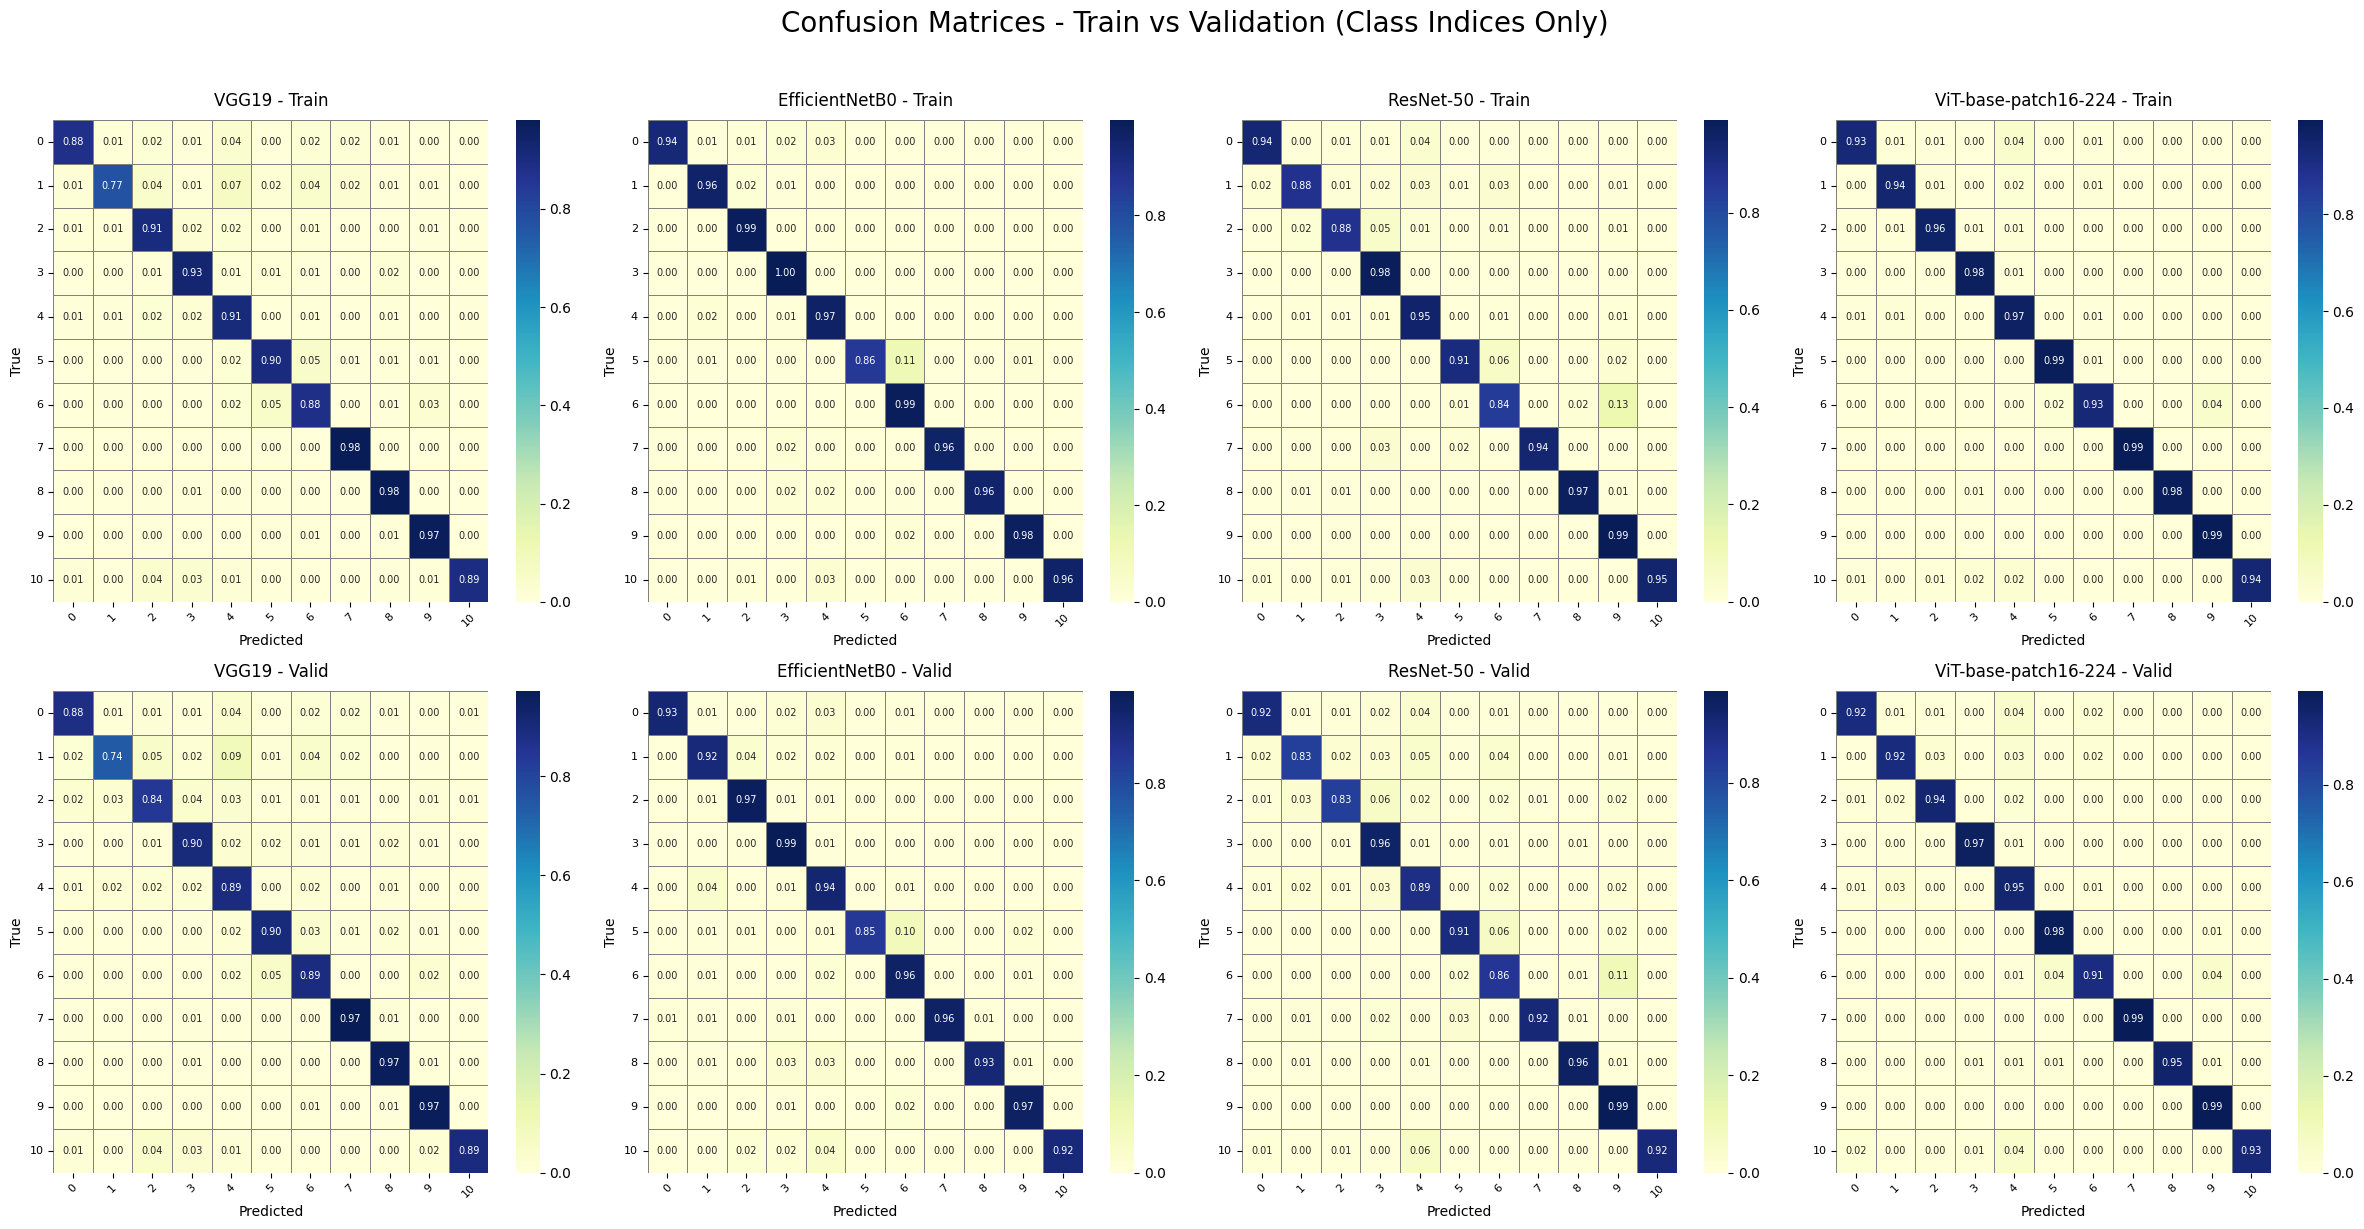

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray', ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# --------------------
# Assuming you have:
# - train_set.classes
# - valid_set.classes
# - train_pred_labels_vgg, valid_pred_labels_vgg
# - train_pred_labels_eff, valid_pred_labels_eff
# - train_pred_labels_res, valid_pred_labels_res
# - train_pred_labels_vit, valid_pred_labels_vit
# --------------------

# Create figure
fig, axs = plt.subplots(2, 4, figsize=(24, 12))  # 2 rows x 4 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_set.classes, train_pred_labels_vgg, "VGG19 - Train")
create_conf_matrix(axs[0, 1], train_set.classes, train_pred_labels_eff, "EfficientNetB0 - Train")
create_conf_matrix(axs[0, 2], train_set.classes, train_pred_labels_res, "ResNet-50 - Train")
create_conf_matrix(axs[0, 3], train_set.classes, train_pred_labels_vit, "ViT-base-patch16-224 - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_set.classes, valid_pred_labels_vgg, "VGG19 - Valid")
create_conf_matrix(axs[1, 1], valid_set.classes, valid_pred_labels_eff, "EfficientNetB0 - Valid")
create_conf_matrix(axs[1, 2], valid_set.classes, valid_pred_labels_res, "ResNet-50 - Valid")
create_conf_matrix(axs[1, 3], valid_set.classes, valid_pred_labels_vit, "ViT-base-patch16-224 - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Train vs Validation (Class Indices Only)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


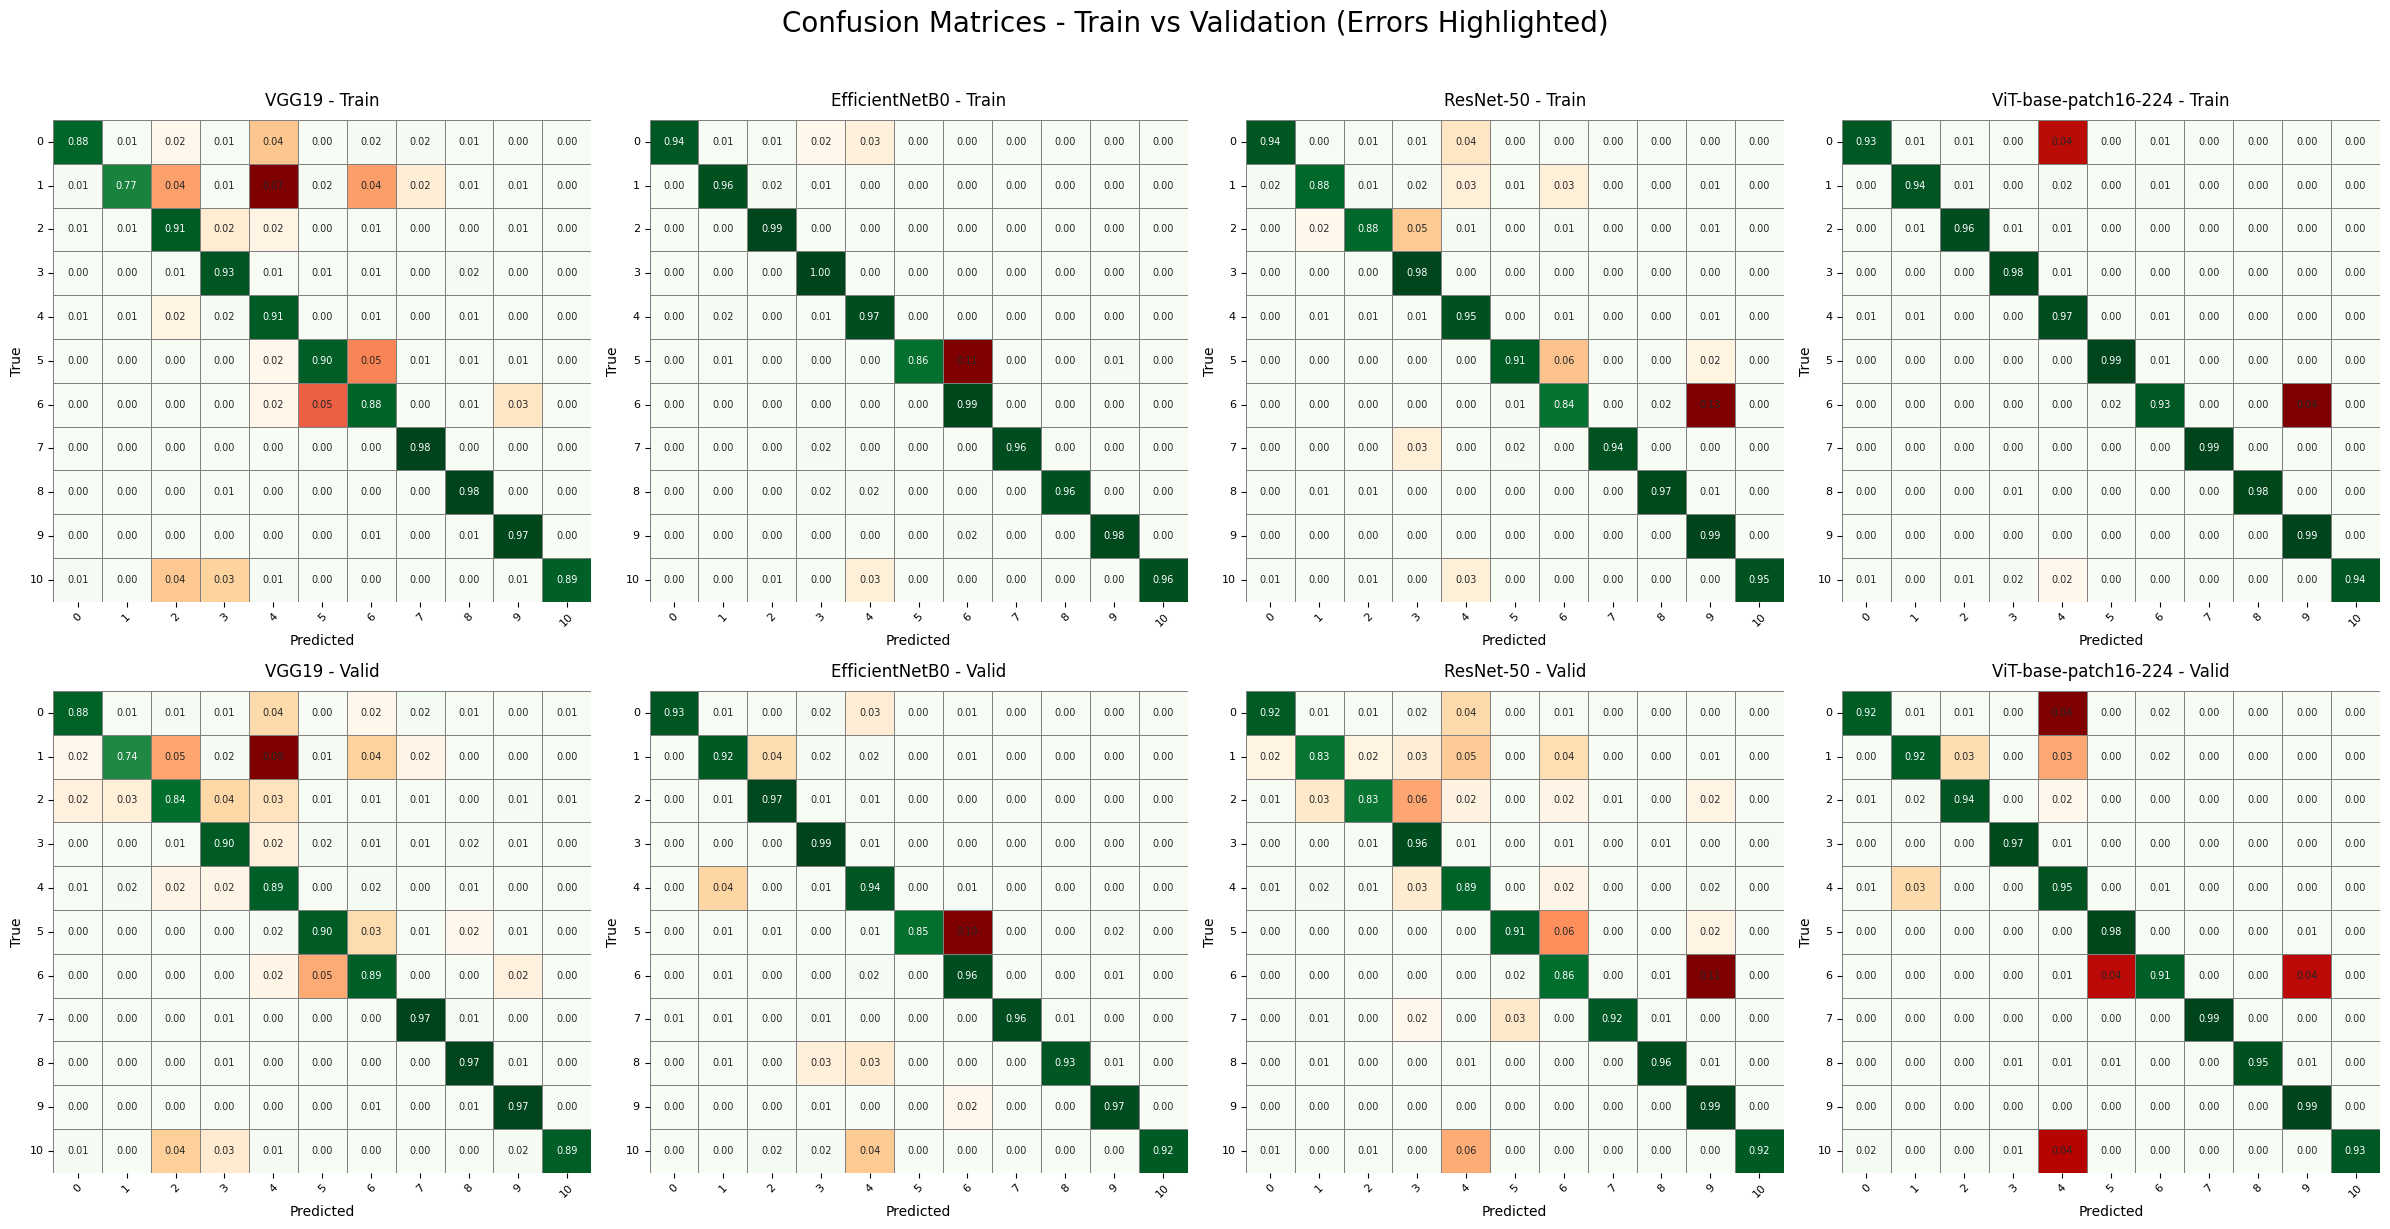

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title, error_threshold=0.02):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    # Copy to modify
    error_cm = cm.copy()

    # Set diagonal (TP) to NaN (so they don't get highlighted)
    np.fill_diagonal(error_cm, np.nan)

    # Apply threshold: very low errors are ignored
    error_cm[error_cm < error_threshold] = np.nan

    # Plot original confusion matrix as light background (correct predictions in green)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    # Overlay error heatmap (highlight serious misclassifications)
    sns.heatmap(error_cm, annot=False, cmap="OrRd",
                xticklabels=indices, yticklabels=indices,
                mask=np.isnan(error_cm),
                linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# ---------------

# Example usage below:

# Assuming you have:
# - train_set.classes
# - valid_set.classes
# - train_pred_labels_vgg, valid_pred_labels_vgg
# - train_pred_labels_eff, valid_pred_labels_eff
# - train_pred_labels_res, valid_pred_labels_res
# - train_pred_labels_vit, valid_pred_labels_vit

# Create figure
fig, axs = plt.subplots(2, 4, figsize=(24, 12))  # 2 rows x 4 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_set.classes, train_pred_labels_vgg, "VGG19 - Train")
create_conf_matrix(axs[0, 1], train_set.classes, train_pred_labels_eff, "EfficientNetB0 - Train")
create_conf_matrix(axs[0, 2], train_set.classes, train_pred_labels_res, "ResNet-50 - Train")
create_conf_matrix(axs[0, 3], train_set.classes, train_pred_labels_vit, "ViT-base-patch16-224 - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_set.classes, valid_pred_labels_vgg, "VGG19 - Valid")
create_conf_matrix(axs[1, 1], valid_set.classes, valid_pred_labels_eff, "EfficientNetB0 - Valid")
create_conf_matrix(axs[1, 2], valid_set.classes, valid_pred_labels_res, "ResNet-50 - Valid")
create_conf_matrix(axs[1, 3], valid_set.classes, valid_pred_labels_vit, "ViT-base-patch16-224 - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Train vs Validation (Errors Highlighted)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


# Dataframe Generation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

def evaluate_model_on_validation(pred_input, true_labels, class_names, model_name, is_labels=False):
    if is_labels:
        pred_labels = pred_input
    else:
        pred_labels = np.argmax(pred_input, axis=1)

    report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

    metrics_dict = {}
    metrics_dict["metric"] = "A P R F"

    for i, class_name in enumerate(class_names):
        class_true = (true_labels == i)
        class_pred = (pred_labels == i)
        acc = (np.sum(class_true & class_pred)) / np.sum(class_true) if np.sum(class_true) > 0 else 0
        prec = report[class_name]['precision']
        rec = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        combined = f"{acc:.4f} {prec:.4f} {rec:.4f} {f1:.4f}"
        metrics_dict[class_name] = combined

    metrics_dict["overall_accuracy"] = accuracy_score(true_labels, pred_labels)
    metrics_dict["hamming_loss"] = hamming_loss(true_labels, pred_labels)

    return pd.DataFrame(metrics_dict, index=[model_name])



In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_table(df, title="Model Evaluation Metrics", fontsize=8):
    fig, ax = plt.subplots(figsize=( len(df.columns) * 2.8, len(df) * 0.6 + 2))
    ax.axis('off')
    ax.axis('tight')

    table = ax.table(cellText=df.round(4).values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.2, 1.2)

    plt.title(title, fontsize=fontsize + 2)
    plt.tight_layout()
    plt.show()


In [ ]:
# Ground truth
valid_true = valid_set.classes
class_names = list(valid_set.class_indices.keys())

# List of model predictions and corresponding names
model_results = [
    ("VGG", valid_preds_vgg),
    ("ResNet50", valid_preds_res),
    ("EfficientNetB0", valid_preds_eff),
    ("ViT Patch-16", valid_preds_vit)
]

# Collect results
df_list = []

for model_name, pred_probs in model_results:
    df = evaluate_model_on_validation(pred_probs, valid_true, class_names, model_name=model_name)
    df_list.append(df)

# Combine all into a single DataFrame
final_df = pd.concat(df_list)

# Display the combined results
print(final_df)


                 metric               Bacterial_spot  \
VGG             A P R F  0.8825 0.9295 0.8825 0.9054   
ResNet50        A P R F  0.9180 0.9518 0.9180 0.9346   
EfficientNetB0  A P R F  0.9331 0.9884 0.9331 0.9599   
ViT Patch-16    A P R F  0.9167 0.9739 0.9167 0.9444   

                               Early_blight                  Late_blight  \
VGG             0.7372 0.9098 0.7372 0.8144  0.8409 0.8904 0.8409 0.8649   
ResNet50        0.8320 0.9052 0.8320 0.8671  0.8308 0.9413 0.8308 0.8826   
EfficientNetB0  0.9222 0.9123 0.9222 0.9172  0.9747 0.9484 0.9747 0.9614   
ViT Patch-16    0.9176 0.9277 0.9176 0.9226  0.9432 0.9602 0.9432 0.9516   

                                  Leaf_Mold           Septoria_leaf_spot  \
VGG             0.9012 0.8916 0.9012 0.8964  0.8901 0.8137 0.8901 0.8502   
ResNet50        0.9553 0.8663 0.9553 0.9086  0.8941 0.8708 0.8941 0.8823   
EfficientNetB0  0.9892 0.9126 0.9892 0.9494  0.9370 0.8985 0.9370 0.9173   
ViT Patch-16    0.9743 0.9836 0.97

In [ ]:
final_df.to_excel("model_evaluation_results.xlsx")

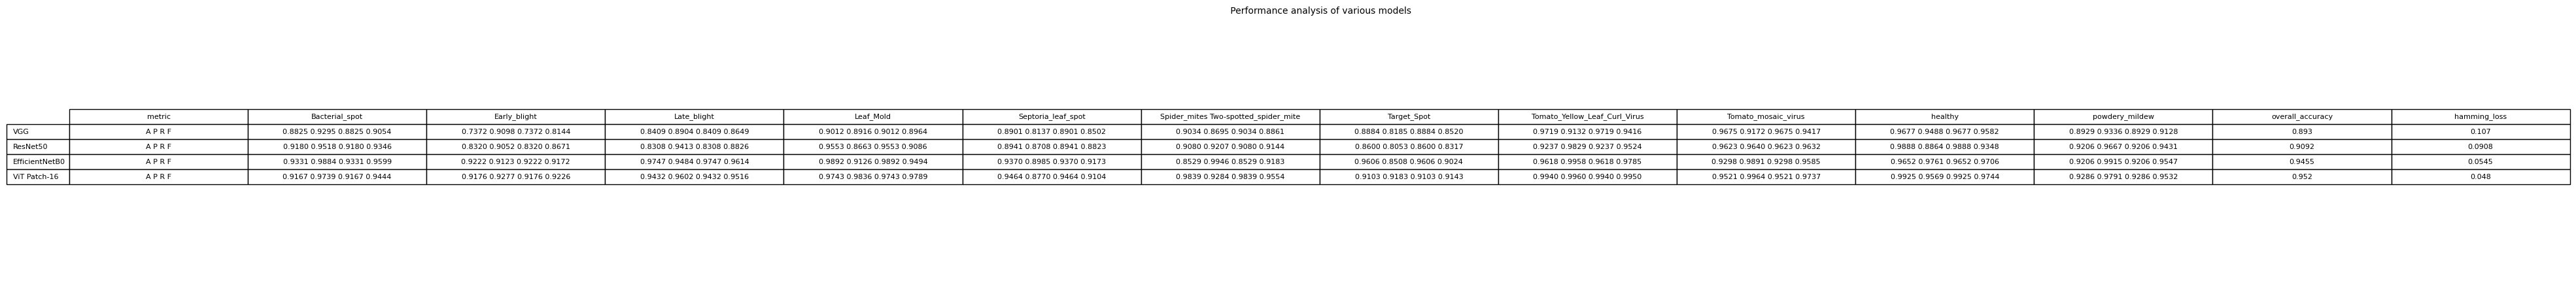

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


# <font color= "lightgreen"> Ensemble - 4base

## Ensemble Model - Soft Voting

In [ ]:
# ----------- SOFT VOTING ENSEMBLE ------------

print("\n🛠️ Soft voting (averaging predictions)...")

# Soft ensemble probabilities
train_preds_ensemble_soft = np.mean(
    np.array([train_preds_vgg, train_preds_eff, train_preds_res, train_preds_vit]),
    axis=0
)

valid_preds_ensemble_soft = np.mean(
    np.array([valid_preds_vgg, valid_preds_eff, valid_preds_res, valid_preds_vit]),
    axis=0
)

# ----------- FINAL ENSEMBLE RESULTS (SOFT) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")
# Soft ensemble predicted classes
train_pred_labels_ensemble_soft = np.argmax(train_preds_ensemble_soft, axis=1)
valid_pred_labels_ensemble_soft = np.argmax(valid_preds_ensemble_soft, axis=1)

# Soft ensemble accuracies
train_accuracy_ensemble_soft = np.mean(train_pred_labels_ensemble_soft == train_labels) * 100
valid_accuracy_ensemble_soft = np.mean(valid_pred_labels_ensemble_soft == valid_labels) * 100

print("\nFinal Ensemble Results (Soft Vote):")
print(f"🧠 Ensemble Training Accuracy (Soft): {train_accuracy_ensemble_soft:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Soft): {valid_accuracy_ensemble_soft:.4f}%")



🛠️ Soft voting (averaging predictions)...

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

Final Ensemble Results (Soft Vote):
🧠 Ensemble Training Accuracy (Soft): 98.9362%
🧪 Ensemble Validation Accuracy (Soft): 97.4263%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (SOFT) ------------
print("\n📊 Calculating macro metrics for soft voting ensemble (validation set only)...")

valid_precision_soft, valid_recall_soft, valid_f1_soft, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_soft,
    average='macro'
)

print(f"\n📈 Soft Ensemble Macro Precision (Valid): {valid_precision_soft:.4f}")
print(f"📈 Soft Ensemble Macro Recall    (Valid): {valid_recall_soft:.4f}")
print(f"📈 Soft Ensemble Macro F1 Score  (Valid): {valid_f1_soft:.4f}")



📊 Calculating macro metrics for soft voting ensemble (validation set only)...

📈 Soft Ensemble Macro Precision (Valid): 0.9752
📈 Soft Ensemble Macro Recall    (Valid): 0.9747
📈 Soft Ensemble Macro F1 Score  (Valid): 0.9748


In [ ]:
# 👇 Evaluate ensemble model and append to final_df
ensemble_results_df = evaluate_model_on_validation(
    valid_preds_ensemble_soft, valid_labels, class_names, model_name="Ensemble 1 - Soft Voting"
)

# Append to the final DataFrame
final_df = pd.concat([final_df, ensemble_results_df])

# Save updated DataFrame to Excel again (optional)
# final_df.to_excel("model_evaluation_results.xlsx")

# Optional: view the updated DataFrame
# print(final_df)


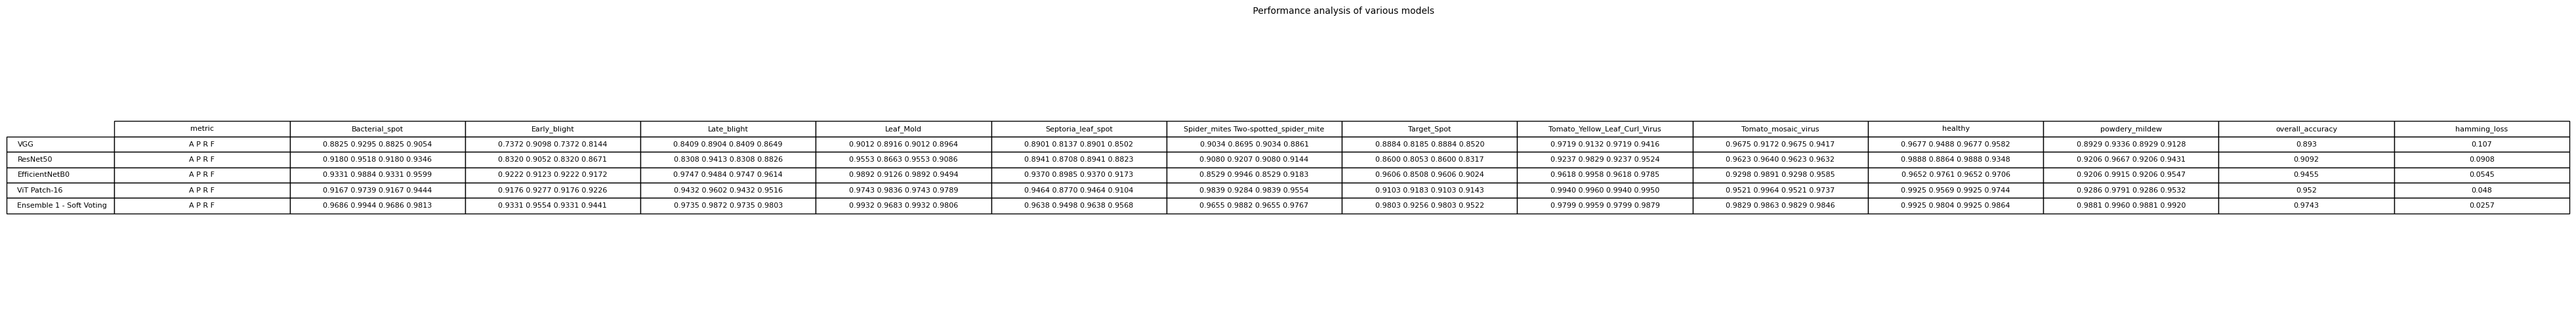

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")



In [ ]:
final_df = final_df.drop("Ensemble - Soft Voting")


## Ensemble Model - Hard Voting

In [ ]:
# ----------- HARD VOTING ENSEMBLE ------------

print("\n🛠️ Hard voting (majority predictions)...")

# Stack individual model predictions
train_preds_stack_hard = np.array([train_preds_vgg, train_preds_eff, train_preds_res, train_preds_vit])
valid_preds_stack_hard = np.array([valid_preds_vgg, valid_preds_eff, valid_preds_res, valid_preds_vit])

# Get class labels from probabilities
train_preds_labels_hard = np.argmax(train_preds_stack_hard, axis=2)  # Shape: (n_models, n_samples)
valid_preds_labels_hard = np.argmax(valid_preds_stack_hard, axis=2)

# Majority voting for each sample
train_pred_labels_ensemble_hard = []
for i in range(train_preds_labels_hard.shape[1]):
    votes = train_preds_labels_hard[:, i]
    majority_vote = np.bincount(votes).argmax()
    train_pred_labels_ensemble_hard.append(majority_vote)
train_pred_labels_ensemble_hard = np.array(train_pred_labels_ensemble_hard)

valid_pred_labels_ensemble_hard = []
for i in range(valid_preds_labels_hard.shape[1]):
    votes = valid_preds_labels_hard[:, i]
    majority_vote = np.bincount(votes).argmax()
    valid_pred_labels_ensemble_hard.append(majority_vote)
valid_pred_labels_ensemble_hard = np.array(valid_pred_labels_ensemble_hard)

# ----------- FINAL ENSEMBLE RESULTS (HARD) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")

# Hard ensemble accuracies
train_accuracy_ensemble_hard = np.mean(train_pred_labels_ensemble_hard == train_labels) * 100
valid_accuracy_ensemble_hard = np.mean(valid_pred_labels_ensemble_hard == valid_labels) * 100

print("\nFinal Ensemble Results (Hard Voting):")
print(f"🧠 Ensemble Training Accuracy (Hard): {train_accuracy_ensemble_hard:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Hard): {valid_accuracy_ensemble_hard:.4f}%")



🛠️ Hard voting (majority predictions)...

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

Final Ensemble Results (Hard Voting):
🧠 Ensemble Training Accuracy (Hard): 98.6151%
🧪 Ensemble Validation Accuracy (Hard): 97.2467%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (HARD) ------------
print("\n📊 Calculating macro metrics for hard voting ensemble (validation set only)...")

valid_precision_hard, valid_recall_hard, valid_f1_hard, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_hard,
    average='macro'
)

print(f"\n📈 Hard Ensemble Macro Precision (Valid): {valid_precision_hard:.4f}")
print(f"📈 Hard Ensemble Macro Recall    (Valid): {valid_recall_hard:.4f}")
print(f"📈 Hard Ensemble Macro F1 Score  (Valid): {valid_f1_hard:.4f}")



📊 Calculating macro metrics for hard voting ensemble (validation set only)...

📈 Hard Ensemble Macro Precision (Valid): 0.9742
📈 Hard Ensemble Macro Recall    (Valid): 0.9721
📈 Hard Ensemble Macro F1 Score  (Valid): 0.9731


In [ ]:
ensemble_results_df_hard = evaluate_model_on_validation(
    valid_pred_labels_ensemble_hard, valid_labels, class_names,
    model_name="Ensemble 1 - Hard Voting", is_labels=True
)

final_df = pd.concat([final_df, ensemble_results_df_hard])


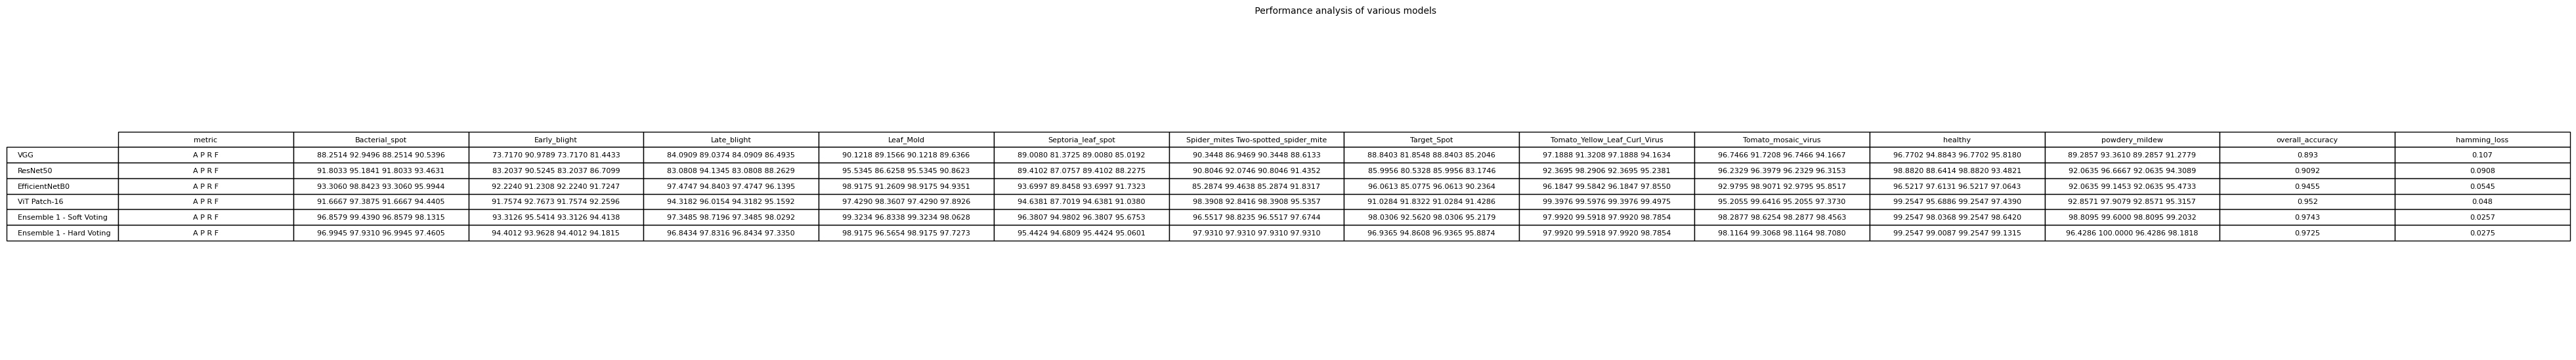

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


## Ensemble Model - Power Weighting

In [ ]:
import numpy as np

# ----------- WEIGHTED ENSEMBLE ------------

print("\n🛠️ Weighted voting (power weighting)...")

# Test accuracies of individual models (replace with actual)
test_accuracies_weighted = np.array([
    valid_accuracy_vgg * 100,
    valid_accuracy_eff * 100,
    valid_accuracy_res * 100,
    valid_accuracy_vit * 100
])

gamma_weighted = 3  # Tunable hyperparameter

# Power-weighted weights calculation
weights_weighted = (test_accuracies_weighted ** gamma_weighted) / np.sum(test_accuracies_weighted ** gamma_weighted)
print(f"📊 Power Weighted Weights (gamma={gamma_weighted}): {weights_weighted}")

# Apply weights to predictions
train_preds_weighted = (
    train_preds_vgg * weights_weighted[0] +
    train_preds_eff * weights_weighted[1] +
    train_preds_res * weights_weighted[2] +
    train_preds_vit * weights_weighted[3]
)

valid_preds_weighted = (
    valid_preds_vgg * weights_weighted[0] +
    valid_preds_eff * weights_weighted[1] +
    valid_preds_res * weights_weighted[2] +
    valid_preds_vit * weights_weighted[3]
)

# Final predicted labels
train_pred_labels_ensemble_weighted = np.argmax(train_preds_weighted, axis=1)
valid_pred_labels_ensemble_weighted = np.argmax(valid_preds_weighted, axis=1)

# ----------- FINAL ENSEMBLE RESULTS (WEIGHTED) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")

train_accuracy_ensemble_weighted = np.mean(train_pred_labels_ensemble_weighted == train_labels) * 100
valid_accuracy_ensemble_weighted = np.mean(valid_pred_labels_ensemble_weighted == valid_labels) * 100

print("\n🔮 Final Weighted Ensemble Results:")
print(f"🧠 Ensemble Training Accuracy (Weighted): {train_accuracy_ensemble_weighted:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Weighted): {valid_accuracy_ensemble_weighted:.4f}%")



🛠️ Weighted voting (power weighting)...
📊 Power Weighted Weights (gamma=3): [0.22453145 0.26652369 0.23694309 0.27200178]

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

🔮 Final Weighted Ensemble Results:
🧠 Ensemble Training Accuracy (Weighted): 99.0020%
🧪 Ensemble Validation Accuracy (Weighted): 97.5909%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (WEIGHTED) ------------
print("\n📊 Calculating macro metrics for weighted ensemble (validation set only)...")

valid_precision_weighted, valid_recall_weighted, valid_f1_weighted, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_weighted,
    average='macro'
)

print(f"\n📈 Weighted Ensemble Macro Precision (Valid): {valid_precision_weighted:.4f}")
print(f"📈 Weighted Ensemble Macro Recall    (Valid): {valid_recall_weighted:.4f}")
print(f"📈 Weighted Ensemble Macro F1 Score  (Valid): {valid_f1_weighted:.4f}")



📊 Calculating macro metrics for weighted ensemble (validation set only)...

📈 Weighted Ensemble Macro Precision (Valid): 0.9769
📈 Weighted Ensemble Macro Recall    (Valid): 0.9764
📈 Weighted Ensemble Macro F1 Score  (Valid): 0.9765


In [ ]:
# 👇 Evaluate weighted ensemble model and append to final_df
ensemble_results_df_weighted = evaluate_model_on_validation(
    valid_preds_weighted, valid_labels, class_names,
    model_name=f"Ensemble 1 - Power Weighted Vote (γ={gamma_weighted})"
)

# Append to the final DataFrame
final_df = pd.concat([final_df, ensemble_results_df_weighted])


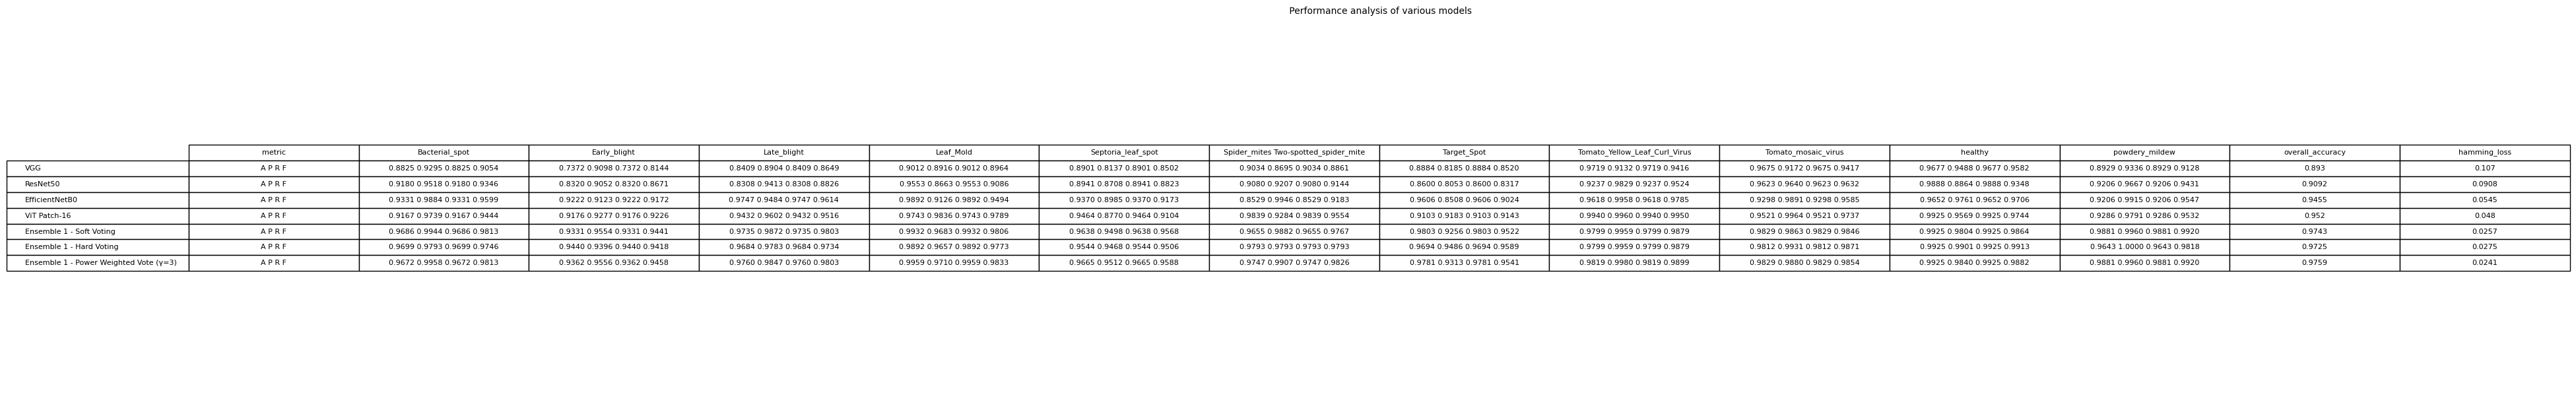

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


## Ensemble Result Table

In [ ]:
import pandas as pd
results = {
    "Model": [
        "Ensemble - Weighted Vote ",
        "Ensemble - Soft Vote",
        "Ensemble - Hard Vote",
        "VGG",
        "EfficientNet",
        "ResNet",
        "ViT"
    ],
    "Training Accuracy (%)": [
        train_accuracy_ensemble_weighted,
        train_accuracy_ensemble_hard,
        train_accuracy_ensemble_soft,
        train_accuracy_vgg,
        train_accuracy_eff,
        train_accuracy_res,
        train_accuracy_vit
    ],
    "Validation Accuracy (%)": [
        valid_accuracy_ensemble_weighted,
        valid_accuracy_ensemble_soft,
        valid_accuracy_ensemble_hard,
        valid_accuracy_vgg,
        valid_accuracy_eff,
        valid_accuracy_res,
        valid_accuracy_vit
    ]
}

results_table = pd.DataFrame(results)

print("\n📊 Final Results Table:\n")
print(results_table.to_string(index=False))


📊 Final Results Table:

                    Model  Training Accuracy (%)  Validation Accuracy (%)
Ensemble - Weighted Vote               99.001973                97.590902
     Ensemble - Soft Vote              98.615141                97.426306
     Ensemble - Hard Vote              98.936211                97.246745
                      VGG              91.083517                89.301212
             EfficientNet              96.328962                94.553344
                   ResNet              93.284592                90.917253
                      ViT              96.530115                95.196768


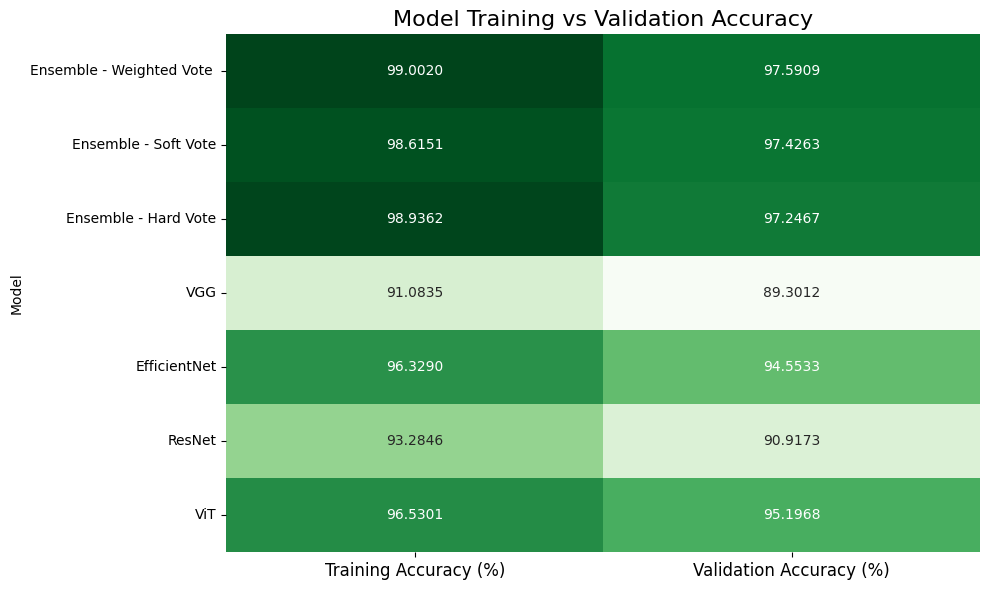

In [ ]:

results_table.set_index("Model", inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(results_table, annot=True, fmt=".4f", cmap="Greens", cbar=False)

plt.title("Model Training vs Validation Accuracy", fontsize=16)
plt.yticks(rotation=0)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


## Ensemble Result Confusion Matrix

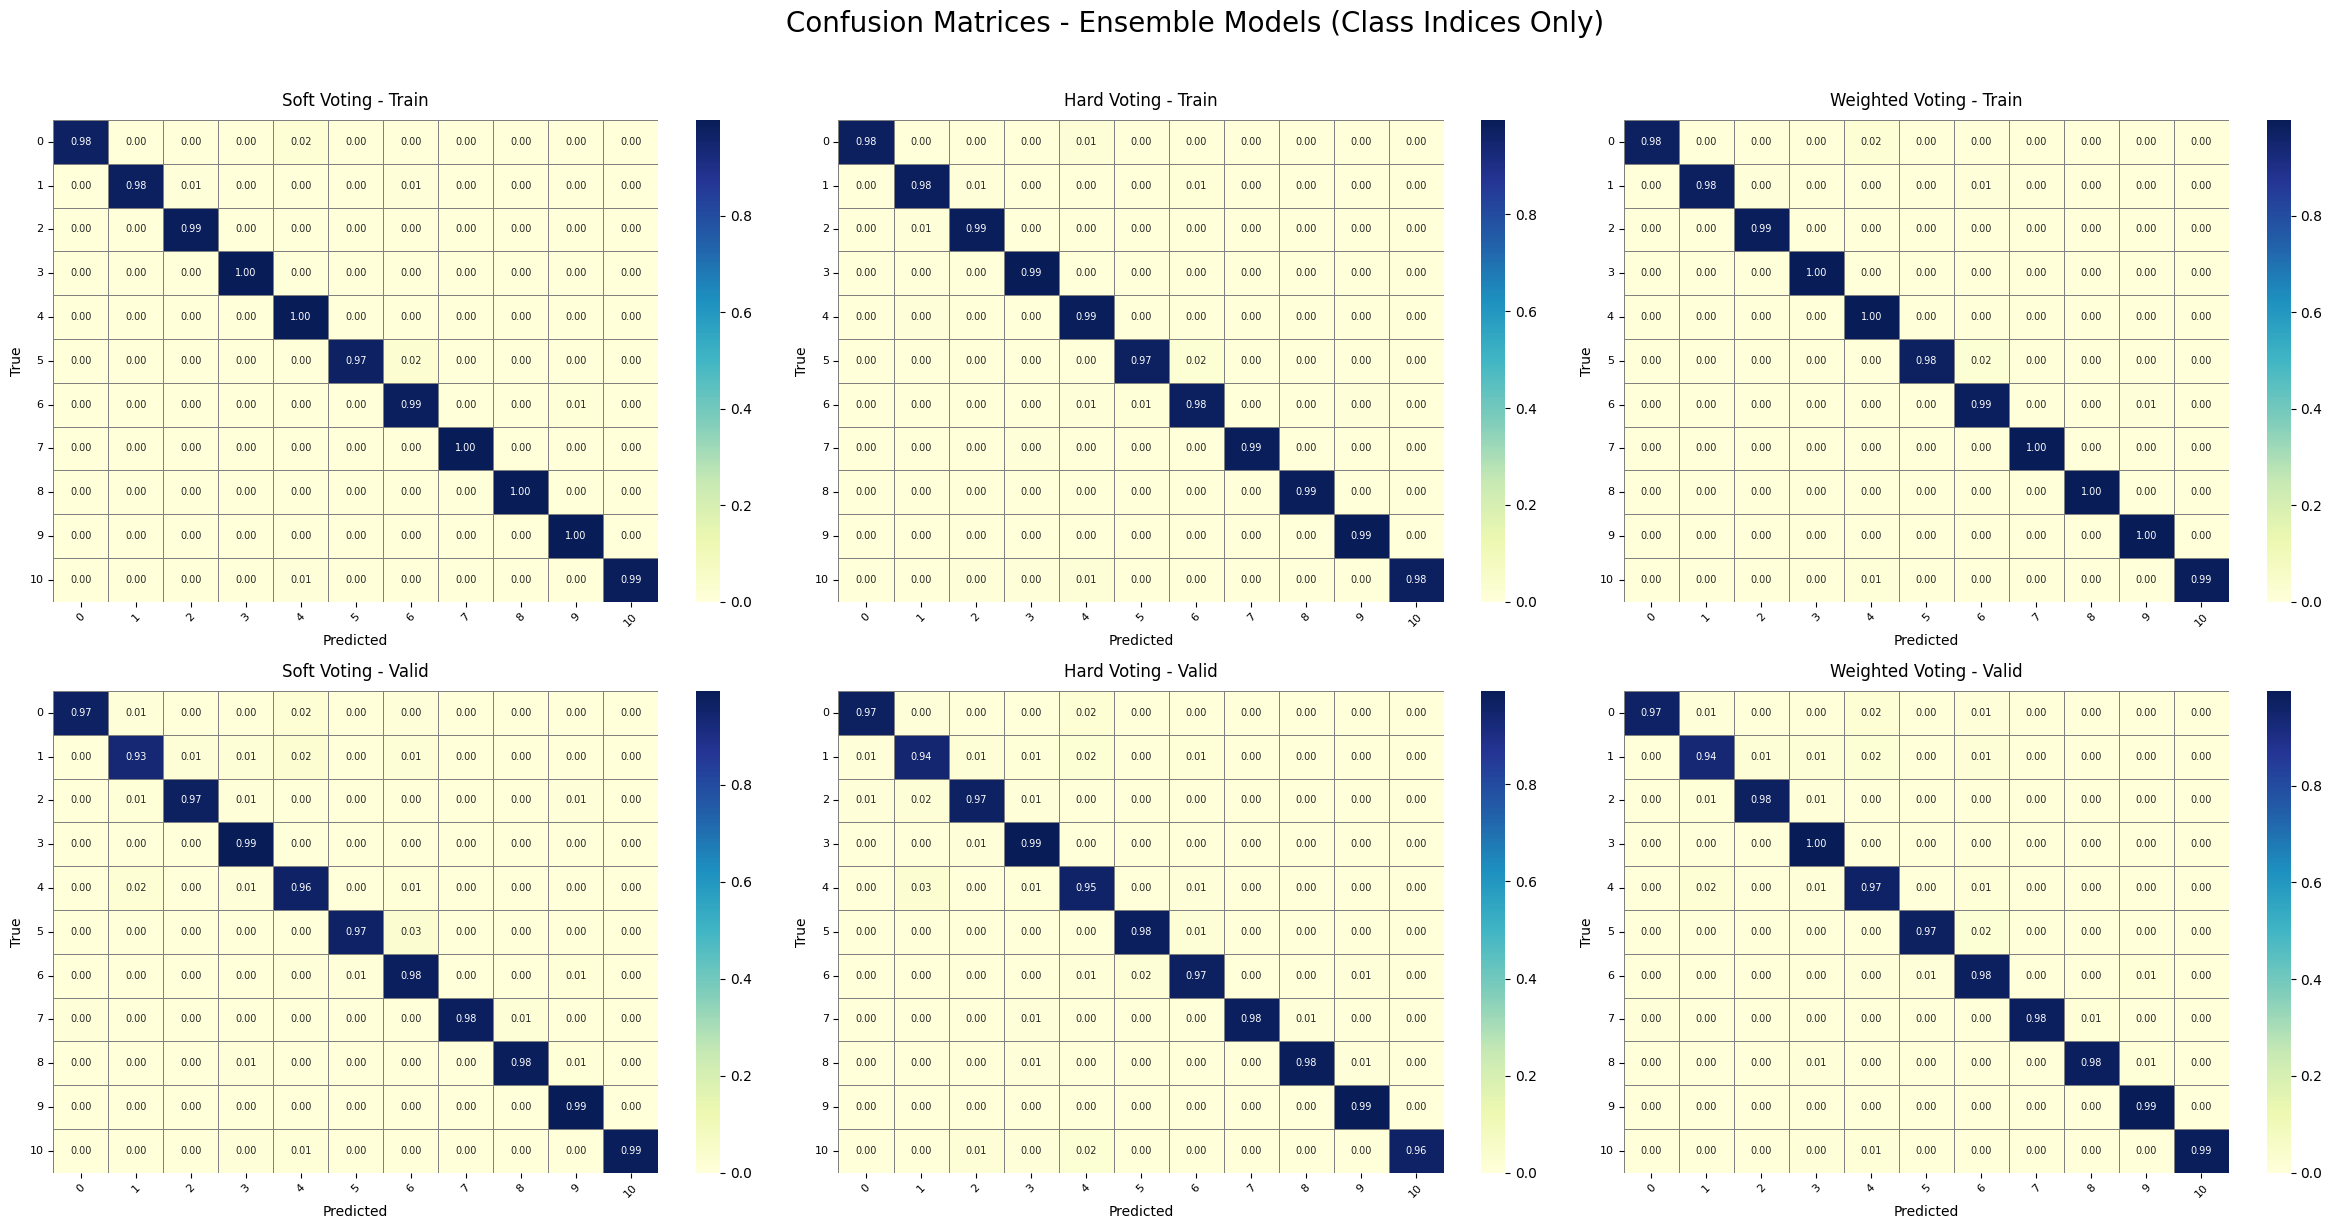

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray', ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# --------------------
# ENSEMBLE predictions assumed:
# - train_pred_labels_ensemble_soft, valid_pred_labels_ensemble_soft
# - train_pred_labels_ensemble_hard, valid_pred_labels_ensemble_hard
# - train_pred_labels_weighted, valid_pred_labels_weighted
# --------------------

# Create figure: 2 rows (Train vs Valid) x 3 columns (Soft, Hard, Weighted)
fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows × 3 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_labels, train_pred_labels_ensemble_soft, "Soft Voting - Train")
create_conf_matrix(axs[0, 1], train_labels, train_pred_labels_ensemble_hard, "Hard Voting - Train")
create_conf_matrix(axs[0, 2], train_labels, train_pred_labels_ensemble_weighted, "Weighted Voting - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_labels, valid_pred_labels_ensemble_soft, "Soft Voting - Valid")
create_conf_matrix(axs[1, 1], valid_labels, valid_pred_labels_ensemble_hard, "Hard Voting - Valid")
create_conf_matrix(axs[1, 2], valid_labels, valid_pred_labels_ensemble_weighted, "Weighted Voting - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Ensemble Models (Class Indices Only)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


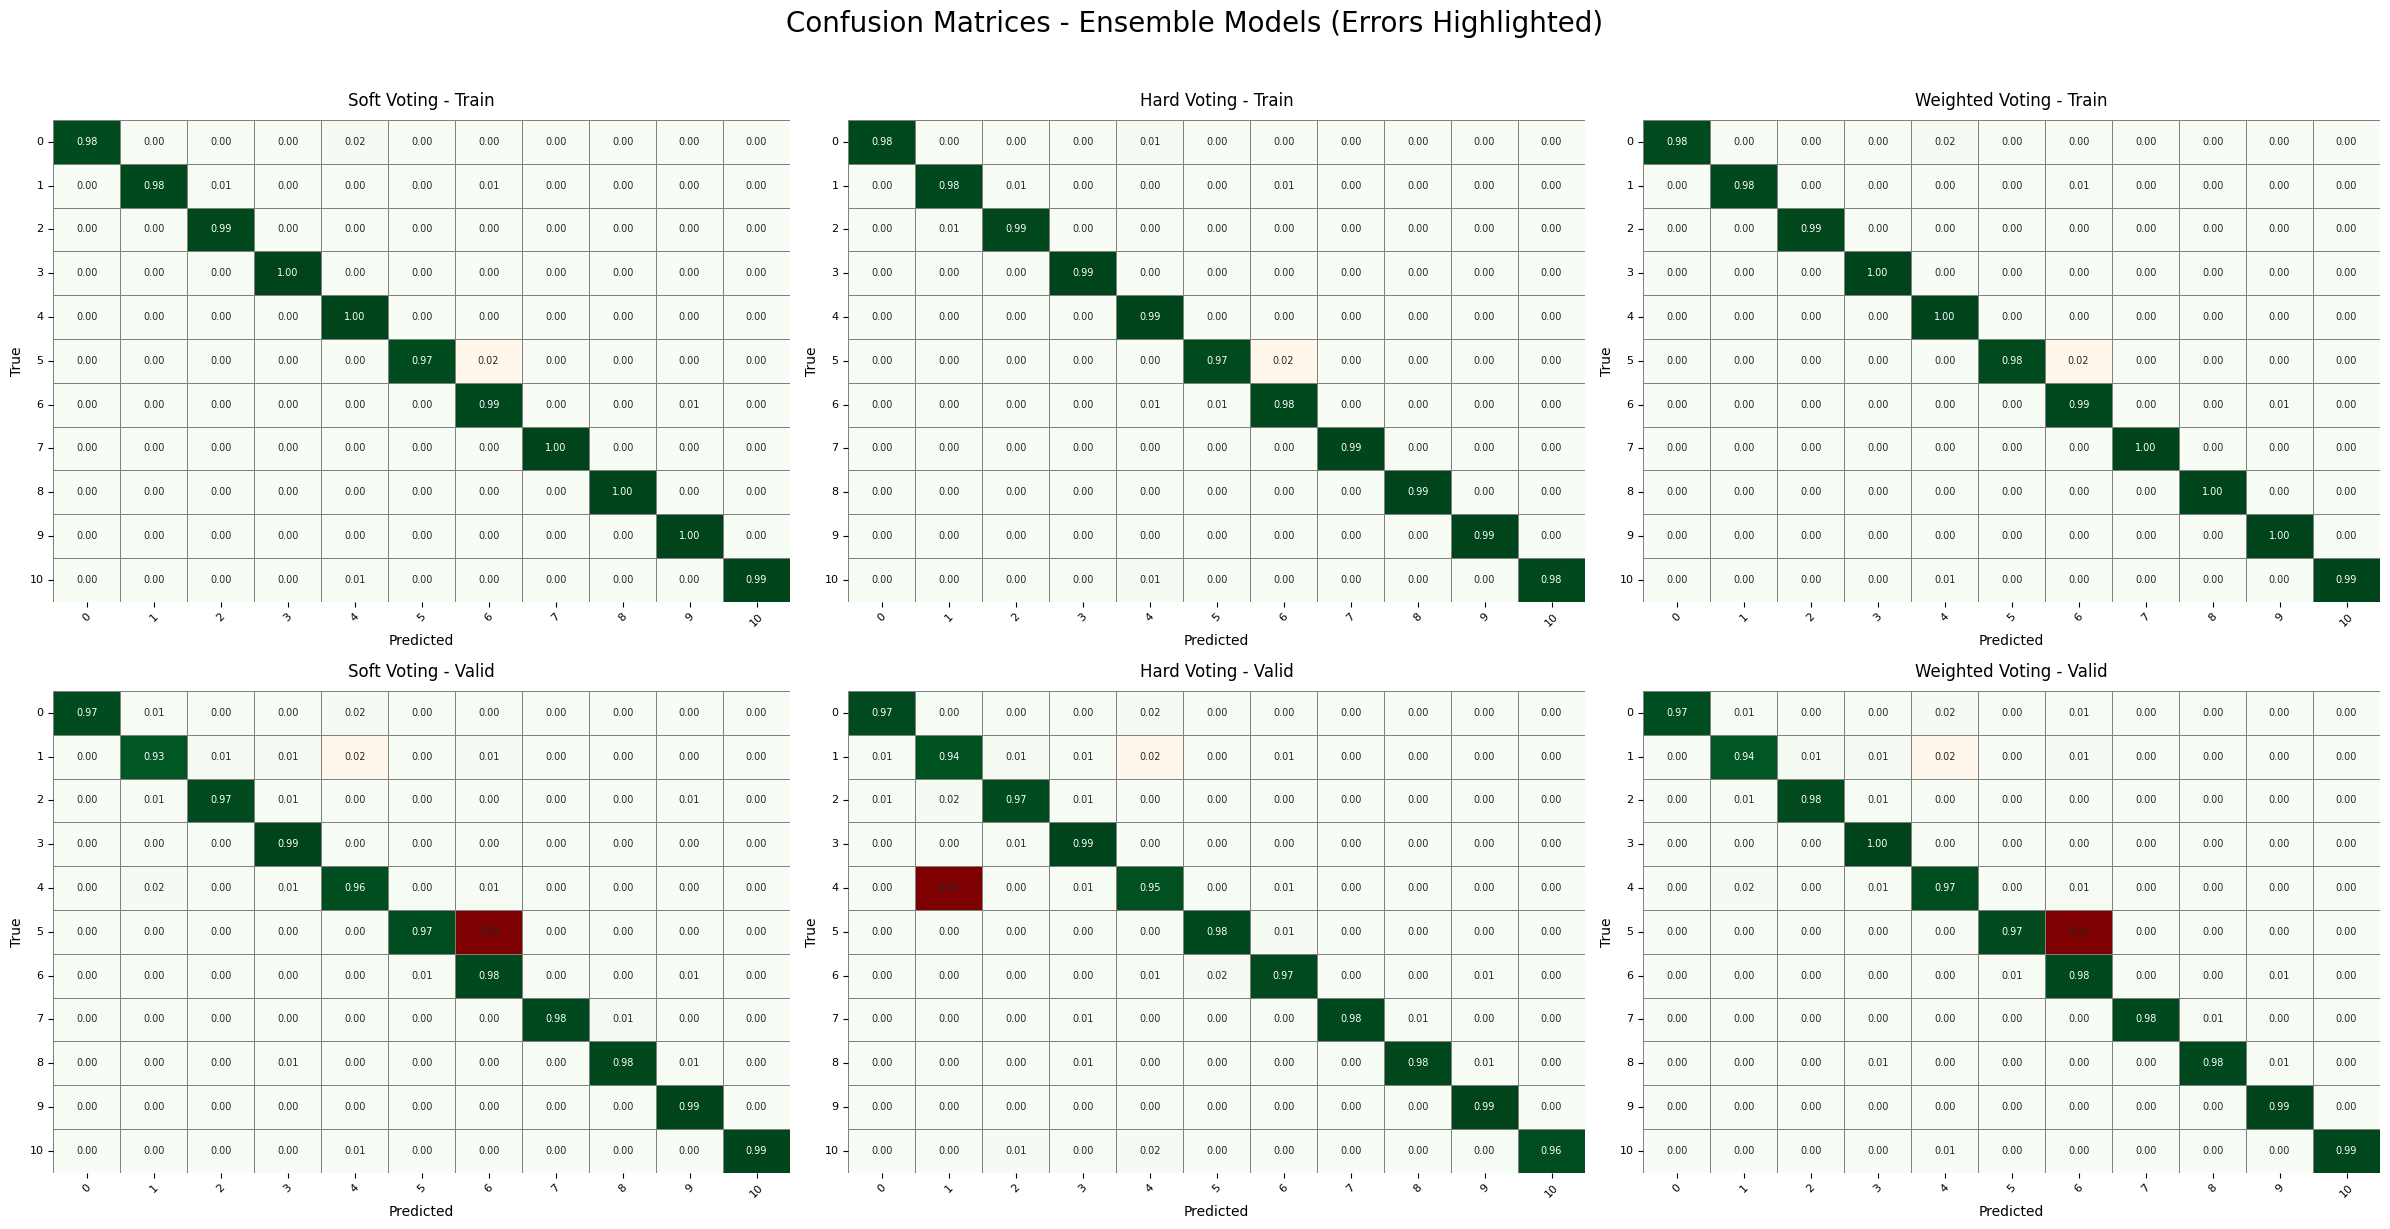

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title, error_threshold=0.02):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    # Copy for highlighting errors
    error_cm = cm.copy()

    # Set diagonal (TP) to NaN so only misclassifications are highlighted
    np.fill_diagonal(error_cm, np.nan)

    # Mask small misclassifications
    error_cm[error_cm < error_threshold] = np.nan

    # Plot background: normal confusion matrix (greens for corrects)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    # Overlay errors: misclassified points (red/orange)
    sns.heatmap(error_cm, annot=False, cmap="OrRd",
                xticklabels=indices, yticklabels=indices,
                mask=np.isnan(error_cm),
                linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# --------------------
# ENSEMBLE predictions assumed:
# - train_pred_labels_ensemble_soft, valid_pred_labels_ensemble_soft
# - train_pred_labels_ensemble_hard, valid_pred_labels_ensemble_hard
# - train_pred_labels_ensemble_weighted, valid_pred_labels_ensemble_weighted
# --------------------

# Create figure: 2 rows (Train vs Valid) x 3 columns (Soft, Hard, Weighted)
fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows × 3 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_labels, train_pred_labels_ensemble_soft, "Soft Voting - Train")
create_conf_matrix(axs[0, 1], train_labels, train_pred_labels_ensemble_hard, "Hard Voting - Train")
create_conf_matrix(axs[0, 2], train_labels, train_pred_labels_ensemble_weighted, "Weighted Voting - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_labels, valid_pred_labels_ensemble_soft, "Soft Voting - Valid")
create_conf_matrix(axs[1, 1], valid_labels, valid_pred_labels_ensemble_hard, "Hard Voting - Valid")
create_conf_matrix(axs[1, 2], valid_labels, valid_pred_labels_ensemble_weighted, "Weighted Voting - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Ensemble Models (Errors Highlighted)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


# <font color = "limegreen"> Ensemble - 3base

## Ensemble Model - Soft Voting

In [ ]:
# ----------- SOFT VOTING ENSEMBLE ------------

print("\n🛠️ Soft voting (averaging predictions)...")

# Soft ensemble probabilities
train_preds_ensemble_soft = np.mean(
    np.array([ train_preds_eff, train_preds_res, train_preds_vit]),
    axis=0
)

valid_preds_ensemble_soft = np.mean(
    np.array([ valid_preds_eff, valid_preds_res, valid_preds_vit]),
    axis=0
)

# ----------- FINAL ENSEMBLE RESULTS (SOFT) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")
# Soft ensemble predicted classes
train_pred_labels_ensemble_soft = np.argmax(train_preds_ensemble_soft, axis=1)
valid_pred_labels_ensemble_soft = np.argmax(valid_preds_ensemble_soft, axis=1)

# Soft ensemble accuracies
train_accuracy_ensemble_soft = np.mean(train_pred_labels_ensemble_soft == train_labels) * 100
valid_accuracy_ensemble_soft = np.mean(valid_pred_labels_ensemble_soft == valid_labels) * 100

print("\nFinal Ensemble Results (Soft Vote):")
print(f"🧠 Ensemble Training Accuracy (Soft): {train_accuracy_ensemble_soft:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Soft): {valid_accuracy_ensemble_soft:.4f}%")



🛠️ Soft voting (averaging predictions)...

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

Final Ensemble Results (Soft Vote):
🧠 Ensemble Training Accuracy (Soft): 98.7892%
🧪 Ensemble Validation Accuracy (Soft): 97.4862%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (SOFT - no VGG) ------------
print("\n📊 Calculating macro metrics for soft voting ensemble (validation set only, no VGG)...")

valid_precision_soft, valid_recall_soft, valid_f1_soft, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_soft,
    average='macro'
)

print(f"\n📈 Soft Ensemble (no VGG) Macro Precision (Valid): {valid_precision_soft:.4f}")
print(f"📈 Soft Ensemble (no VGG) Macro Recall    (Valid): {valid_recall_soft:.4f}")
print(f"📈 Soft Ensemble (no VGG) Macro F1 Score  (Valid): {valid_f1_soft:.4f}")



📊 Calculating macro metrics for soft voting ensemble (validation set only, no VGG)...

📈 Soft Ensemble (no VGG) Macro Precision (Valid): 0.9761
📈 Soft Ensemble (no VGG) Macro Recall    (Valid): 0.9752
📈 Soft Ensemble (no VGG) Macro F1 Score  (Valid): 0.9754


In [ ]:
# 👇 Evaluate soft ensemble (3 models) and append to final_df
ensemble_results_df_soft_3 = evaluate_model_on_validation(
    valid_preds_ensemble_soft, valid_labels, class_names,
    model_name="Ensemble 2 - Soft Voting"
)

final_df = pd.concat([final_df, ensemble_results_df_soft_3])


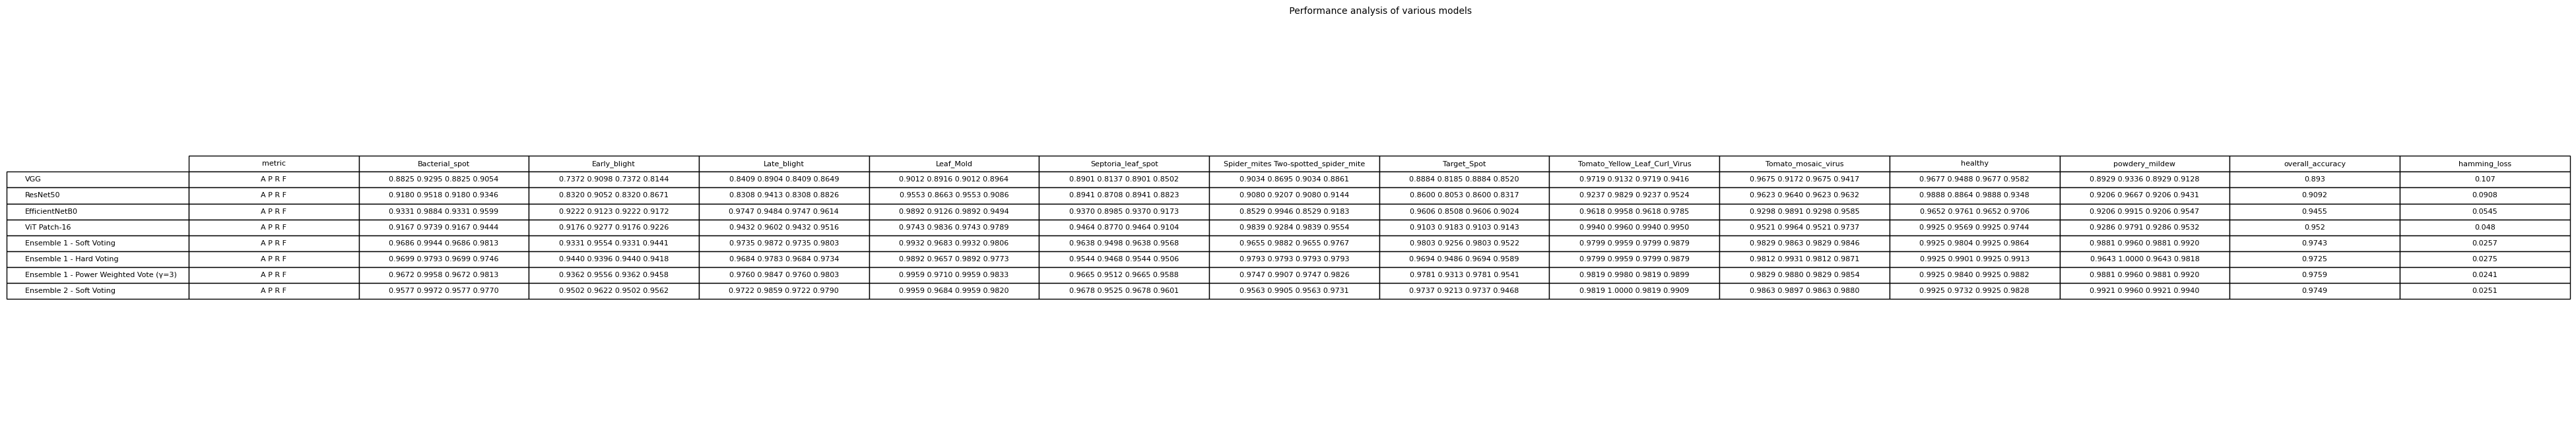

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


## Ensemble Model - Hard Voting

In [ ]:
# ----------- HARD VOTING ENSEMBLE ------------

print("\n🛠️ Hard voting (majority predictions)...")

# Stack individual model predictions
train_preds_stack_hard = np.array([ train_preds_eff, train_preds_res, train_preds_vit])
valid_preds_stack_hard = np.array([ valid_preds_eff, valid_preds_res, valid_preds_vit])

# Get class labels from probabilities
train_preds_labels_hard = np.argmax(train_preds_stack_hard, axis=2)  # Shape: (n_models, n_samples)
valid_preds_labels_hard = np.argmax(valid_preds_stack_hard, axis=2)

# Majority voting for each sample
train_pred_labels_ensemble_hard = []
for i in range(train_preds_labels_hard.shape[1]):
    votes = train_preds_labels_hard[:, i]
    majority_vote = np.bincount(votes).argmax()
    train_pred_labels_ensemble_hard.append(majority_vote)
train_pred_labels_ensemble_hard = np.array(train_pred_labels_ensemble_hard)

valid_pred_labels_ensemble_hard = []
for i in range(valid_preds_labels_hard.shape[1]):
    votes = valid_preds_labels_hard[:, i]
    majority_vote = np.bincount(votes).argmax()
    valid_pred_labels_ensemble_hard.append(majority_vote)
valid_pred_labels_ensemble_hard = np.array(valid_pred_labels_ensemble_hard)

# ----------- FINAL ENSEMBLE RESULTS (HARD) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")

# Hard ensemble accuracies
train_accuracy_ensemble_hard = np.mean(train_pred_labels_ensemble_hard == train_labels) * 100
valid_accuracy_ensemble_hard = np.mean(valid_pred_labels_ensemble_hard == valid_labels) * 100

print("\nFinal Ensemble Results (Hard Voting):")
print(f"🧠 Ensemble Training Accuracy (Hard): {train_accuracy_ensemble_hard:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Hard): {valid_accuracy_ensemble_hard:.4f}%")



🛠️ Hard voting (majority predictions)...

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

Final Ensemble Results (Hard Voting):
🧠 Ensemble Training Accuracy (Hard): 98.3637%
🧪 Ensemble Validation Accuracy (Hard): 96.9475%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (HARD - no VGG) ------------
print("\n📊 Calculating macro metrics for hard voting ensemble (validation set only, no VGG)...")

valid_precision_hard, valid_recall_hard, valid_f1_hard, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_hard,
    average='macro'
)

print(f"\n📈 Hard Ensemble (no VGG) Macro Precision (Valid): {valid_precision_hard:.4f}")
print(f"📈 Hard Ensemble (no VGG) Macro Recall    (Valid): {valid_recall_hard:.4f}")
print(f"📈 Hard Ensemble (no VGG) Macro F1 Score  (Valid): {valid_f1_hard:.4f}")



📊 Calculating macro metrics for hard voting ensemble (validation set only, no VGG)...

📈 Hard Ensemble (no VGG) Macro Precision (Valid): 0.9710
📈 Hard Ensemble (no VGG) Macro Recall    (Valid): 0.9687
📈 Hard Ensemble (no VGG) Macro F1 Score  (Valid): 0.9697


In [ ]:
# 👇 Evaluate hard ensemble (3 models) and append to final_df
ensemble_results_df_hard_3 = evaluate_model_on_validation(
    valid_pred_labels_ensemble_hard, valid_labels, class_names,
    model_name="Ensemble 2 - Hard Voting", is_labels=True
)

final_df = pd.concat([final_df, ensemble_results_df_hard_3])


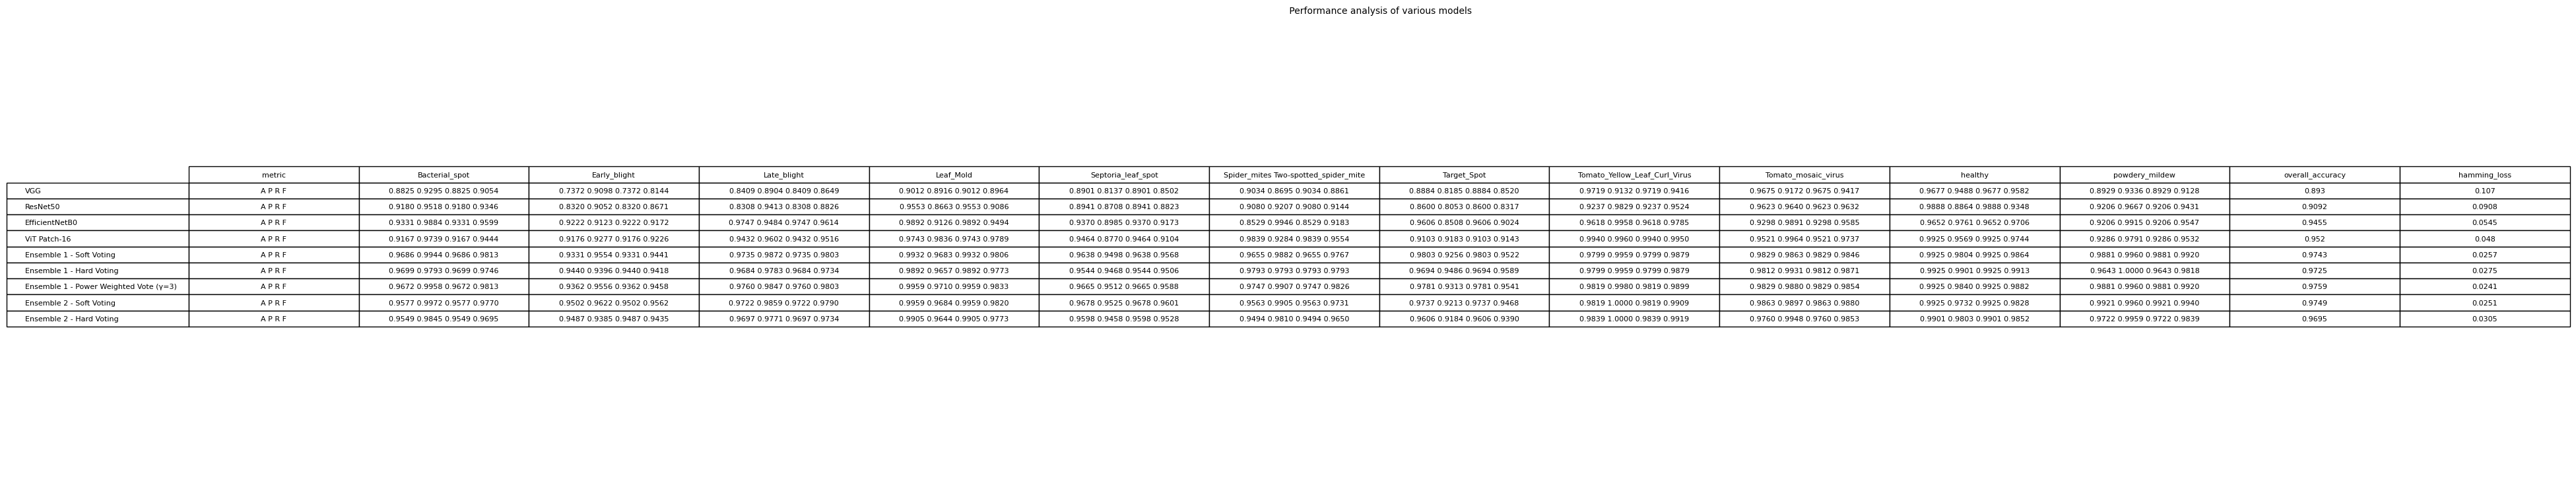

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


## Ensemble Model - Power Weighting

In [ ]:
import numpy as np

# ----------- WEIGHTED ENSEMBLE ------------

print("\n🛠️ Weighted voting (power weighting)...")

# Test accuracies of individual models (replace with actual)
test_accuracies_weighted = np.array([
    valid_accuracy_eff * 100,
    valid_accuracy_res * 100,
    valid_accuracy_vit * 100
])

gamma_weighted = 22  # Tunable hyperparameter

# Power-weighted weights calculation
weights_weighted = (test_accuracies_weighted ** gamma_weighted) / np.sum(test_accuracies_weighted ** gamma_weighted)
print(f"📊 Power Weighted Weights (gamma={gamma_weighted}): {weights_weighted}")

# Apply weights to predictions
train_preds_weighted = (
    train_preds_eff * weights_weighted[0] +
    train_preds_res * weights_weighted[1] +
    train_preds_vit * weights_weighted[2]
)

valid_preds_weighted = (
    valid_preds_eff * weights_weighted[0] +
    valid_preds_res * weights_weighted[1] +
    valid_preds_vit * weights_weighted[2]
)

# Final predicted labels
train_pred_labels_ensemble_weighted = np.argmax(train_preds_weighted, axis=1)
valid_pred_labels_ensemble_weighted = np.argmax(valid_preds_weighted, axis=1)

# ----------- FINAL ENSEMBLE RESULTS (WEIGHTED) ------------

print("\n📋 Extracting true labels...")
train_labels = train_set.classes
valid_labels = valid_set.classes

print("\n🔎 Decoding ensemble predictions...")

train_accuracy_ensemble_weighted = np.mean(train_pred_labels_ensemble_weighted == train_labels) * 100
valid_accuracy_ensemble_weighted = np.mean(valid_pred_labels_ensemble_weighted == valid_labels) * 100

print("\n🔮 Final Weighted Ensemble Results:")
print(f"🧠 Ensemble Training Accuracy (Weighted): {train_accuracy_ensemble_weighted:.4f}%")
print(f"🧪 Ensemble Validation Accuracy (Weighted): {valid_accuracy_ensemble_weighted:.4f}%")



🛠️ Weighted voting (power weighting)...
📊 Power Weighted Weights (gamma=22): [0.3871588  0.16338649 0.44945471]

📋 Extracting true labels...

🔎 Decoding ensemble predictions...

🔮 Final Weighted Ensemble Results:
🧠 Ensemble Training Accuracy (Weighted): 98.8318%
🧪 Ensemble Validation Accuracy (Weighted): 97.7256%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# ----------- METRICS: MACRO PRECISION / RECALL / F1 (WEIGHTED) ------------
print("\n📊 Calculating macro metrics for weighted ensemble (validation set only)...")

valid_precision_weighted, valid_recall_weighted, valid_f1_weighted, _ = precision_recall_fscore_support(
    valid_labels,
    valid_pred_labels_ensemble_weighted,
    average='macro'
)

print(f"\n📈 Weighted Ensemble Macro Precision (Valid): {valid_precision_weighted:.4f}")
print(f"📈 Weighted Ensemble Macro Recall    (Valid): {valid_recall_weighted:.4f}")
print(f"📈 Weighted Ensemble Macro F1 Score  (Valid): {valid_f1_weighted:.4f}")



📊 Calculating macro metrics for weighted ensemble (validation set only)...

📈 Weighted Ensemble Macro Precision (Valid): 0.9783
📈 Weighted Ensemble Macro Recall    (Valid): 0.9784
📈 Weighted Ensemble Macro F1 Score  (Valid): 0.9783


In [ ]:
# 👇 Evaluate weighted ensemble (3 models) and append to final_df
ensemble_results_df_weighted_3 = evaluate_model_on_validation(
    valid_preds_weighted, valid_labels, class_names,
    model_name=f"Ensemble 2 - Power Weighted (, γ={gamma_weighted})"
)

final_df = pd.concat([final_df, ensemble_results_df_weighted_3])


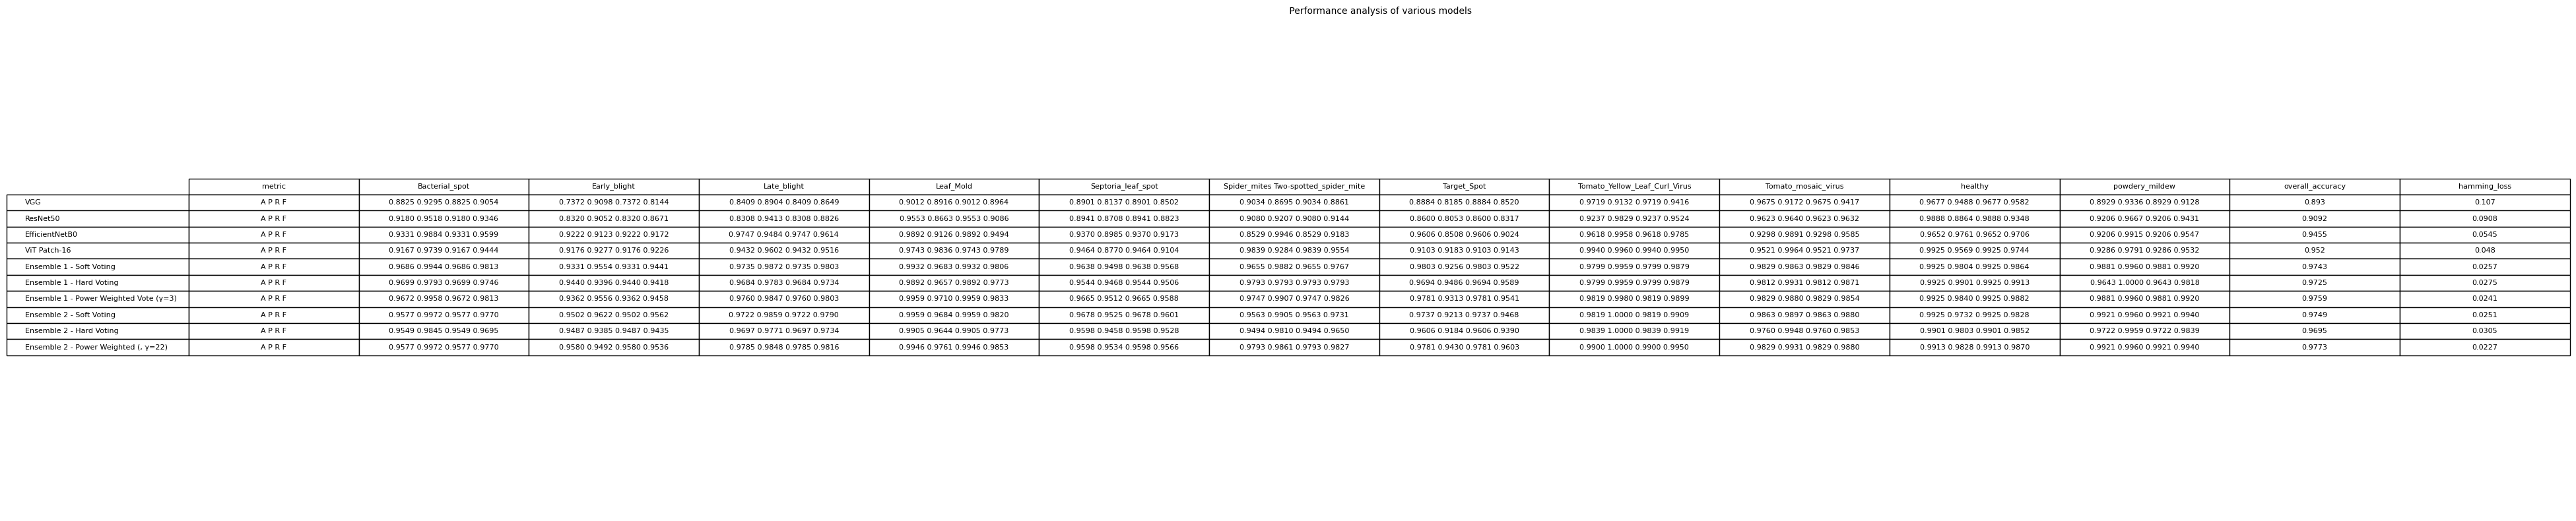

In [ ]:
plot_metrics_table(final_df, title=" Performance analysis of various models")


In [ ]:
final_df.to_excel("model_evaluation_results.xlsx")

In [ ]:
import numpy as np

print("\n🛠️ Weighted voting (power weighting) sweep...")

# Test accuracies of individual models (replace with actual)
test_accuracies_weighted = np.array([
    valid_accuracy_eff * 100,
    valid_accuracy_res * 100,
    valid_accuracy_vit * 100
])

# Store best validation result
best_valid_acc = 0
best_train_acc = 0
best_gamma = None
best_weights = None

# Sweep gamma from 1 to 100
for gamma_weighted in range(1, 60):
    weights_power = test_accuracies_weighted ** gamma_weighted
    weights_weighted = weights_power / np.sum(weights_power)

    # Apply weights to predictions
    train_preds_weighted = (
        train_preds_eff * weights_weighted[0] +
        train_preds_res * weights_weighted[1] +
        train_preds_vit * weights_weighted[2]
    )

    valid_preds_weighted = (
        valid_preds_eff * weights_weighted[0] +
        valid_preds_res * weights_weighted[1] +
        valid_preds_vit * weights_weighted[2]
    )

    train_pred_labels_ensemble_weighted = np.argmax(train_preds_weighted, axis=1)
    valid_pred_labels_ensemble_weighted = np.argmax(valid_preds_weighted, axis=1)

    train_accuracy_ensemble_weighted = np.mean(train_pred_labels_ensemble_weighted == train_set.classes) * 100
    valid_accuracy_ensemble_weighted = np.mean(valid_pred_labels_ensemble_weighted == valid_set.classes) * 100

    # Track best validation accuracy
    if valid_accuracy_ensemble_weighted > best_valid_acc:
        best_valid_acc = valid_accuracy_ensemble_weighted
        best_train_acc = train_accuracy_ensemble_weighted
        best_gamma = gamma_weighted
        best_weights = weights_weighted.copy()

# Final output
print("\n🔮 Best Weighted Ensemble Result (based on Validation Accuracy):")
print(f"🎯 Best Validation Accuracy: {best_valid_acc:.4f}%")
print(f"🏋️ Corresponding Training Accuracy: {best_train_acc:.4f}%")
print(f"📈 Achieved at Gamma: {best_gamma}")
print(f"⚖️ Weights at Best Gamma (Eff, Res, ViT): {best_weights}")



🛠️ Weighted voting (power weighting) sweep...

🔮 Best Weighted Ensemble Result (based on Validation Accuracy):
🎯 Best Validation Accuracy: 97.7256%
🏋️ Corresponding Training Accuracy: 98.8318%
📈 Achieved at Gamma: 22
⚖️ Weights at Best Gamma (Eff, Res, ViT): [0.3871588  0.16338649 0.44945471]


## Ensemble Result Table

In [ ]:
import pandas as pd
results = {
    "Model": [
        "Ensemble 2 - Weighted Vote ",
        "Ensemble 2 - Soft Vote",
        "Ensemble 2 - Hard Vote",
        "EfficientNet",
        "ResNet",
        "ViT"
    ],
    "Training Accuracy (%)": [
        train_accuracy_ensemble_weighted,
        train_accuracy_ensemble_hard,
        train_accuracy_ensemble_soft,
        train_accuracy_eff,
        train_accuracy_res,
        train_accuracy_vit
    ],
    "Validation Accuracy (%)": [
        valid_accuracy_ensemble_weighted,
        valid_accuracy_ensemble_soft,
        valid_accuracy_ensemble_hard,
        valid_accuracy_eff,
        valid_accuracy_res,
        valid_accuracy_vit
    ]
}

results_table = pd.DataFrame(results)

print("\n📊 Final Results Table:\n")
print(results_table.to_string(index=False))


📊 Final Results Table:

                      Model  Training Accuracy (%)  Validation Accuracy (%)
Ensemble 2 - Weighted Vote               98.831767                97.725572
     Ensemble 2 - Soft Vote              98.363700                97.486159
     Ensemble 2 - Hard Vote              98.789215                96.947479
               EfficientNet              96.328962                94.553344
                     ResNet              93.284592                90.917253
                        ViT              96.530115                95.196768


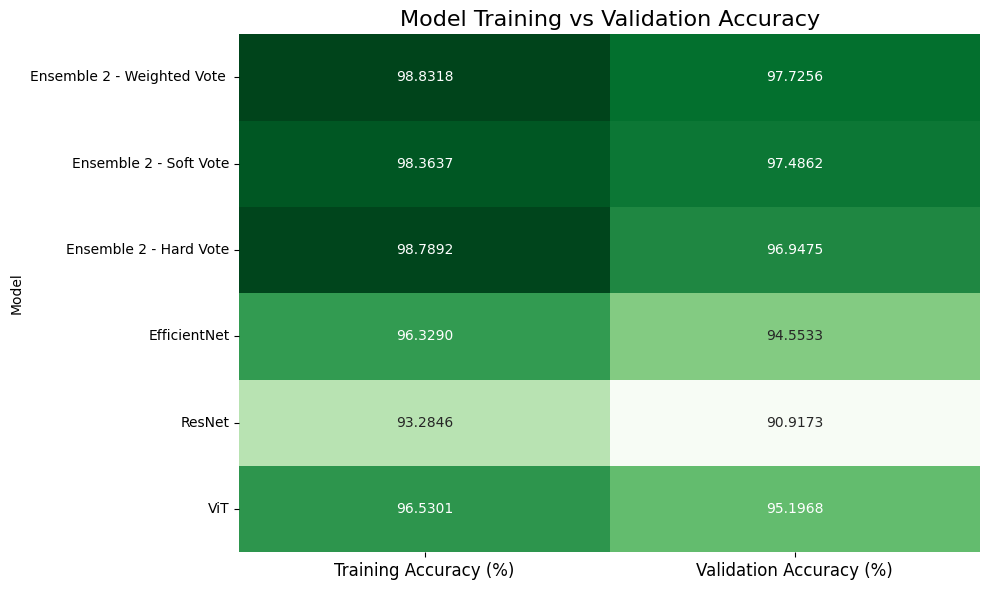

In [ ]:

results_table.set_index("Model", inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(results_table, annot=True, fmt=".4f", cmap="Greens", cbar=False)

plt.title("Model Training vs Validation Accuracy", fontsize=16)
plt.yticks(rotation=0)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()


## Ensemble Result Confusion Matrix

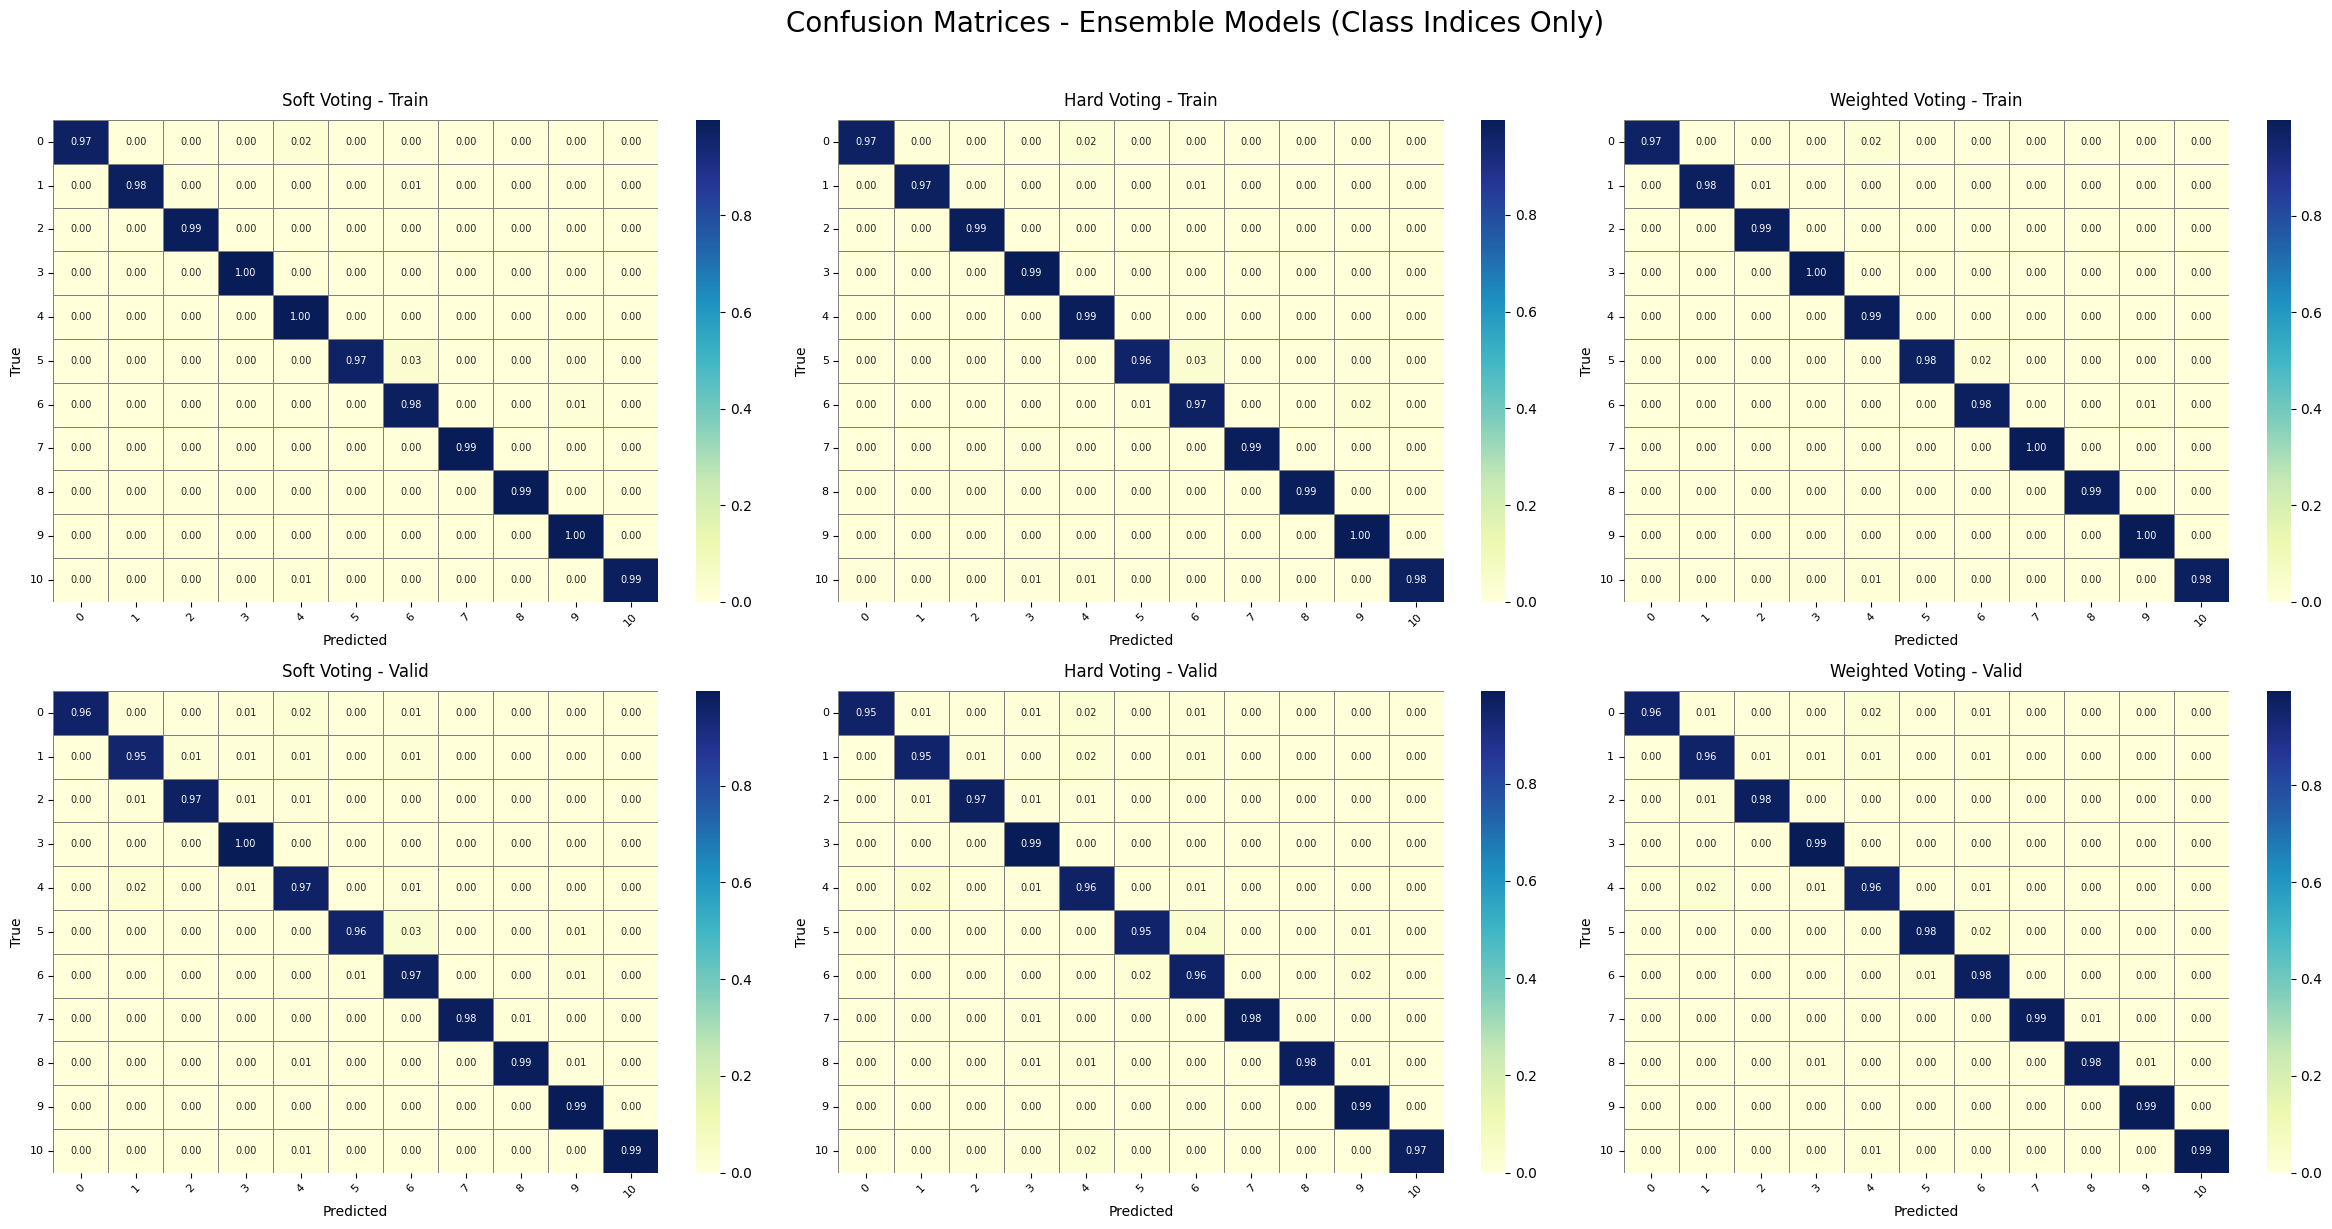

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray', ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# --------------------
# ENSEMBLE predictions assumed:
# - train_pred_labels_ensemble_soft, valid_pred_labels_ensemble_soft
# - train_pred_labels_ensemble_hard, valid_pred_labels_ensemble_hard
# - train_pred_labels_weighted, valid_pred_labels_weighted
# --------------------

# Create figure: 2 rows (Train vs Valid) x 3 columns (Soft, Hard, Weighted)
fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows × 3 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_labels, train_pred_labels_ensemble_soft, "Soft Voting - Train")
create_conf_matrix(axs[0, 1], train_labels, train_pred_labels_ensemble_hard, "Hard Voting - Train")
create_conf_matrix(axs[0, 2], train_labels, train_pred_labels_ensemble_weighted, "Weighted Voting - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_labels, valid_pred_labels_ensemble_soft, "Soft Voting - Valid")
create_conf_matrix(axs[1, 1], valid_labels, valid_pred_labels_ensemble_hard, "Hard Voting - Valid")
create_conf_matrix(axs[1, 2], valid_labels, valid_pred_labels_ensemble_weighted, "Weighted Voting - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Ensemble Models (Class Indices Only)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


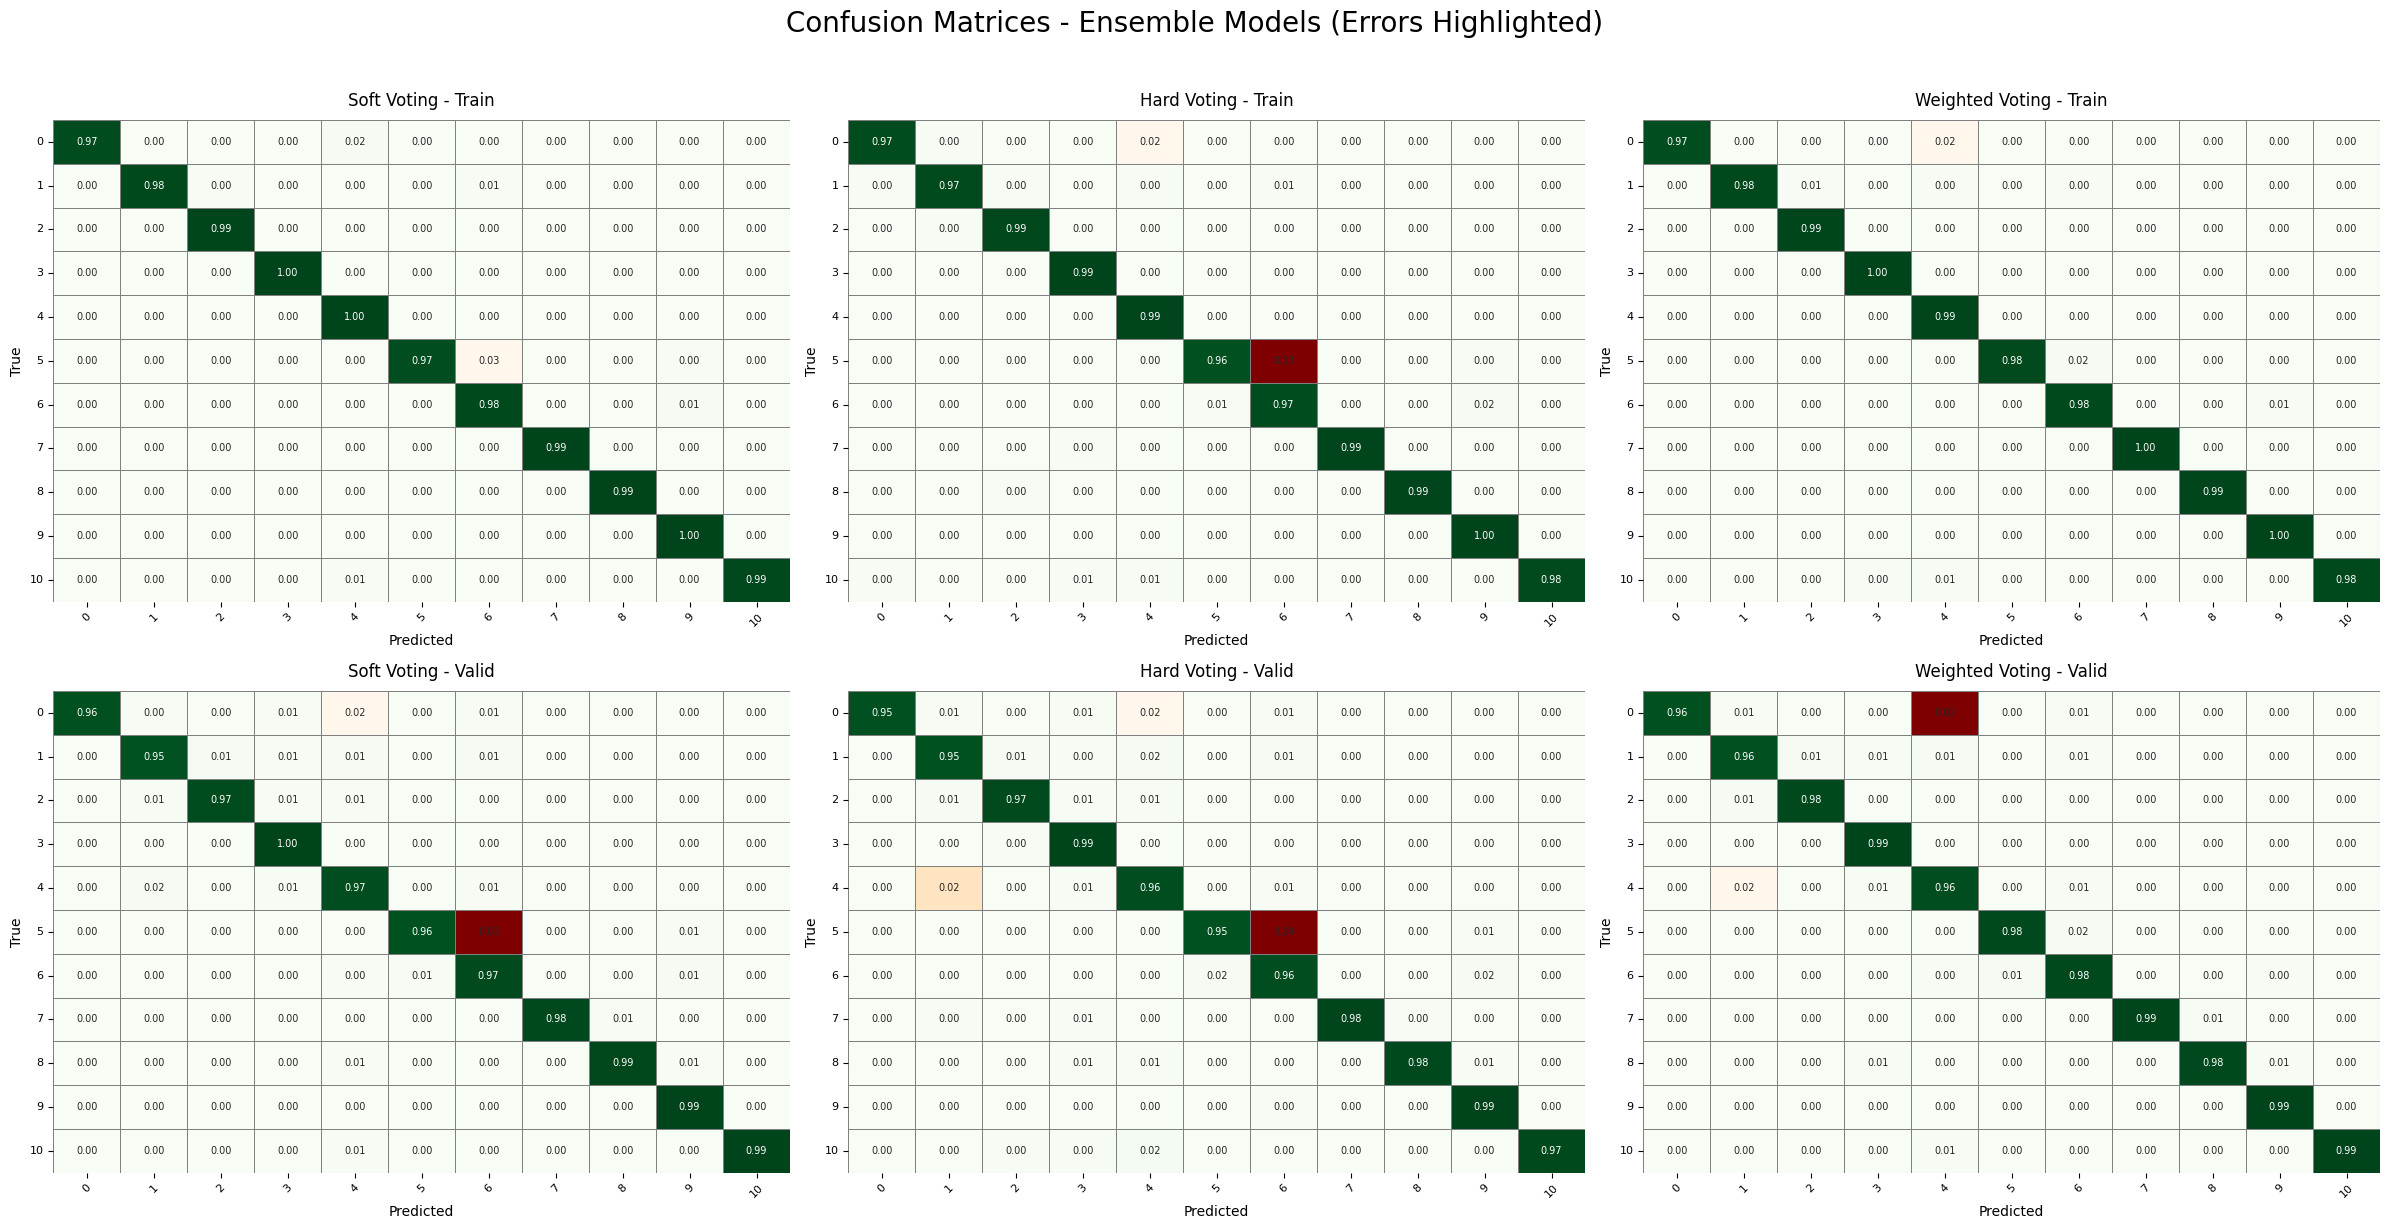

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title, error_threshold=0.02):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    # Copy for highlighting errors
    error_cm = cm.copy()

    # Set diagonal (TP) to NaN so only misclassifications are highlighted
    np.fill_diagonal(error_cm, np.nan)

    # Mask small misclassifications
    error_cm[error_cm < error_threshold] = np.nan

    # Plot background: normal confusion matrix (greens for corrects)
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    # Overlay errors: misclassified points (red/orange)
    sns.heatmap(error_cm, annot=False, cmap="OrRd",
                xticklabels=indices, yticklabels=indices,
                mask=np.isnan(error_cm),
                linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)

# --------------------
# ENSEMBLE predictions assumed:
# - train_pred_labels_ensemble_soft, valid_pred_labels_ensemble_soft
# - train_pred_labels_ensemble_hard, valid_pred_labels_ensemble_hard
# - train_pred_labels_ensemble_weighted, valid_pred_labels_ensemble_weighted
# --------------------

# Create figure: 2 rows (Train vs Valid) x 3 columns (Soft, Hard, Weighted)
fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows × 3 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_labels, train_pred_labels_ensemble_soft, "Soft Voting - Train")
create_conf_matrix(axs[0, 1], train_labels, train_pred_labels_ensemble_hard, "Hard Voting - Train")
create_conf_matrix(axs[0, 2], train_labels, train_pred_labels_ensemble_weighted, "Weighted Voting - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_labels, valid_pred_labels_ensemble_soft, "Soft Voting - Valid")
create_conf_matrix(axs[1, 1], valid_labels, valid_pred_labels_ensemble_hard, "Hard Voting - Valid")
create_conf_matrix(axs[1, 2], valid_labels, valid_pred_labels_ensemble_weighted, "Weighted Voting - Valid")

# Final touches
fig.suptitle("Confusion Matrices - Ensemble Models (Errors Highlighted)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


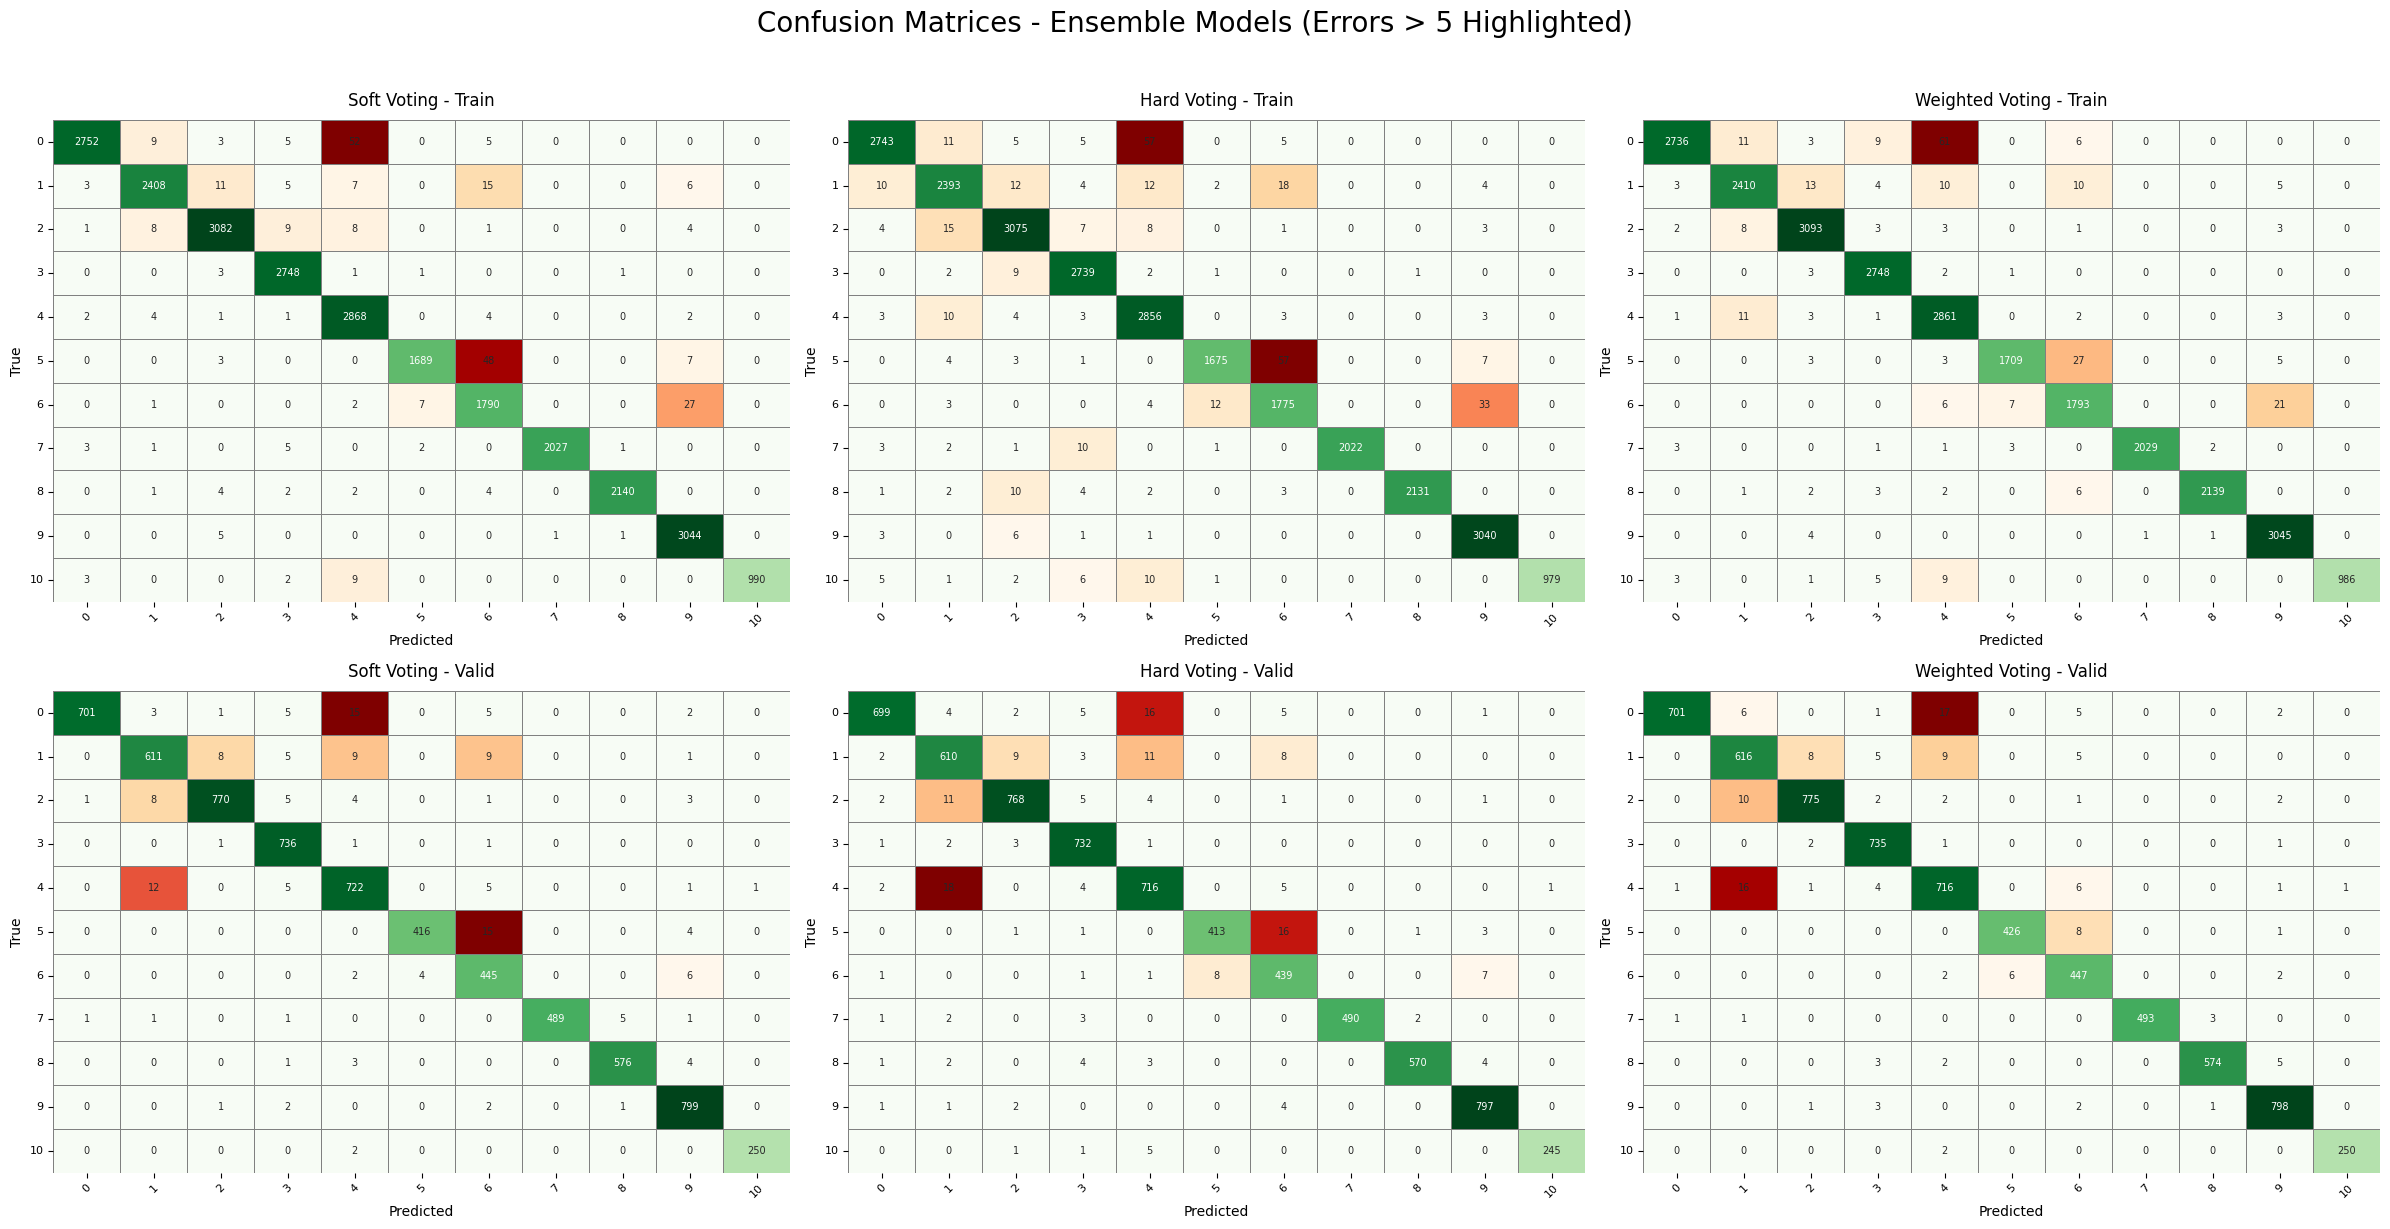

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_conf_matrix(ax, y_true, y_pred, title, error_threshold=5):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    indices = list(range(num_classes))

    # Convert to float so we can use NaN for highlighting
    error_cm = cm.astype(float)

    # Set diagonal (TP) to NaN so only misclassifications are highlighted
    np.fill_diagonal(error_cm, np.nan)

    # Mask small misclassifications (< threshold count)
    error_cm[error_cm <= error_threshold] = np.nan

    # Plot background: confusion matrix (greens for corrects)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=indices, yticklabels=indices,
                annot_kws={"size": 7}, linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    # Overlay errors: misclassified points (red/orange)
    sns.heatmap(error_cm, annot=False, cmap="OrRd",
                xticklabels=indices, yticklabels=indices,
                mask=np.isnan(error_cm),
                linewidths=0.5, linecolor='gray',
                cbar=False, ax=ax)

    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylabel('True', fontsize=10)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', rotation=0, labelsize=8)


# --------------------
# ENSEMBLE predictions assumed:
# - train_pred_labels_ensemble_soft, valid_pred_labels_ensemble_soft
# - train_pred_labels_ensemble_hard, valid_pred_labels_ensemble_hard
# - train_pred_labels_ensemble_weighted, valid_pred_labels_ensemble_weighted
# --------------------

fig, axs = plt.subplots(2, 3, figsize=(24, 12))  # 2 rows × 3 columns

# First row: TRAIN predictions
create_conf_matrix(axs[0, 0], train_labels, train_pred_labels_ensemble_soft, "Soft Voting - Train")
create_conf_matrix(axs[0, 1], train_labels, train_pred_labels_ensemble_hard, "Hard Voting - Train")
create_conf_matrix(axs[0, 2], train_labels, train_pred_labels_ensemble_weighted, "Weighted Voting - Train")

# Second row: VALID predictions
create_conf_matrix(axs[1, 0], valid_labels, valid_pred_labels_ensemble_soft, "Soft Voting - Valid")
create_conf_matrix(axs[1, 1], valid_labels, valid_pred_labels_ensemble_hard, "Hard Voting - Valid")
create_conf_matrix(axs[1, 2], valid_labels, valid_pred_labels_ensemble_weighted, "Weighted Voting - Valid")

fig.suptitle("Confusion Matrices - Ensemble Models (Errors > 5 Highlighted)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()
